In [12]:
from functools import partial
from typing import List, Optional, Union

import einops
import json
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA
import plotly.io as pio
import torch
from circuitsvis.attention import attention_heads
from fancy_einsum import einsum
from IPython.display import HTML, IFrame
from jaxtyping import Float
from tqdm import tqdm

import transformer_lens.utils as utils
from transformer_lens import ActivationCache, HookedTransformer

In [2]:
import seaborn as sns
sns.set_theme(
    context="paper",
    style="white",  # 'whitegrid', 'dark', 'darkgrid', ...
    palette="colorblind",
    font="DejaVu Sans",  # 'serif'
    font_scale=1.75,  # 1.75, 2, ...
)

In [3]:
torch.set_grad_enabled(False)
print("Disabled automatic differentiation")

Disabled automatic differentiation


In [4]:
# import dotenv
# config = dotenv.dotenv_values(".env.default")
# model_name = config["MODEL_NAME"]
# g_file_path = config["G_FILE_PATH"]

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer

# Correct model name: "gpt2"
model_name = "google/gemma-2b"

# Load the GPT-2 small model and tokenizer
model = AutoModelForCausalLM.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [55]:
### load unembdding vectors ###
# .eigh does not work on MPS :(
device = 'cpu'
unembedding_matrix = model.lm_head.weight.detach().to(device)
W, d = unembedding_matrix.shape
# center around the origin in the d-dim space
per_channel_mean = torch.mean(unembedding_matrix, dim = 0)
centered_unembed = unembedding_matrix - per_channel_mean

# compute Covariance of Unembed matrix -> [d,d]
Cov_gamma = centered_unembed.T @ centered_unembed / W

In [56]:
# find eigenvectors of Cov matrix = PCA !
eigenvalues, eigenvectors = torch.linalg.eigh(Cov_gamma.to('cpu'))
eigenvalues = eigenvalues #.to('mps')
eigenvectors = eigenvectors #.to('mps') # d principle components 
# eigenbasis is orthogonal -> easy to find inverse
# Matrix is Square, hence Eigendecomp and SVD are identical 
# and singular values are sqrt(eigenvalue)
# taking 1/singular gives us std along each PC
inv_sqrt_Cov_gamma = eigenvectors @ torch.diag(1/torch.sqrt(eigenvalues)) @ eigenvectors.T
# and direct sqrt - like Laplacian normalization [by degree], in spectral domain
sqrt_Cov_gamma = eigenvectors @ torch.diag(torch.sqrt(eigenvalues)) @ eigenvectors.T
# this gives new "Unmbedding Matrix" called here `g` - it is whitened version of the original matrix
# though unlike sparse PCA/SVD we do not drop any high-frequency components explicitly
g = centered_unembed @ inv_sqrt_Cov_gamma

In [57]:
unembedding_matrix = unembedding_matrix.to(device)
centered_unembed = centered_unembed.to(device)
sqrt_Cov_gamma = sqrt_Cov_gamma.to(device)
inv_sqrt_Cov_gamma = inv_sqrt_Cov_gamma.to(device)
g = g.to(device)

In [58]:
# hmmmm the total size of embedding vectors is much larger (???)
g.norm(dim=1)

tensor([  8.1564,  62.3746, 150.2072,  ...,  45.4618,  43.7304,   8.1311])

In [59]:
# check non-diagonal cov elements
g_cent_bar = torch.mean(g, dim = 0)
g_cent = g - g_cent_bar

gg = (g.T @ g / W)
cc = (g_cent.T @ g_cent / W)

# Display max and mean of non-diagonal elements of covariance matrices
print('abs max off-diag cov:', [round(r,7) for r in [Cov_gamma.fill_diagonal_(0).abs().max().item(), gg.fill_diagonal_(0).abs().max().item(), cc.fill_diagonal_(0).abs().max().item()]])
print('abs mean off-diag cov:', [round(r,7) for r in [Cov_gamma.fill_diagonal_(0).abs().mean().item(), gg.fill_diagonal_(0).abs().mean().item(), cc.fill_diagonal_(0).abs().mean().item()]])

abs max off-diag cov: [0.1028244, 0.008399, 0.0083991]
abs mean off-diag cov: [0.0023342, 2.31e-05, 2.31e-05]


In [60]:
def get_counterfactual_pairs_original(words_pairs, take_first = False):
    base_ind = []
    target_ind = []

    add_bos = True if not take_first else False

    for i in range(len(words_pairs)):
        first = tokenizer.encode(words_pairs[i][0], add_special_tokens=add_bos)
        second = tokenizer.encode(words_pairs[i][1], add_special_tokens=add_bos)
        # they take only two-token words with non-equal last tokens
        # and then select only the last token from the two-token word
        # actually the first token for original tokenizer is always <bos>! so they do take the first token!
        if take_first:
            base_ind.append(first[0])
            target_ind.append(second[0])
        else:
            if len(first) == len(second) == 2 and first[1] != second[1]:
                base_ind.append(first[1])
                target_ind.append(second[1])
            
    base_name = [tokenizer.decode(i) for i in base_ind]
    target_name = [tokenizer.decode(i) for i in target_ind]

    return base_ind, target_ind, base_name, target_name


def concept_direction(base_ind, target_ind, data):
    base_data = data[base_ind,:]
    target_data = data[target_ind,:]

    diff_data = target_data - base_data
    mean_diff_data = torch.mean(diff_data, dim = 0)
    mean_diff_data = mean_diff_data / torch.norm(mean_diff_data)

    return mean_diff_data, diff_data

def inner_product_loo(base_ind, target_ind, data):
    # loo ~ least one out
    # compare one with the mean?
    # why? it should just have small projection onto the mean
    base_data = data[base_ind,:]
    target_data = data[target_ind,:]

    diff_data = target_data - base_data
    products = []
    for i in range(diff_data.shape[0]):
        mask = torch.ones(diff_data.shape[0], dtype = bool)
        mask[i] = False
        loo_diff = diff_data[mask]
        mean_diff_data = torch.mean(loo_diff, dim = 0)
        loo_mean = mean_diff_data / torch.norm(mean_diff_data)
        products.append(loo_mean @ diff_data[i])
    return torch.stack(products), diff_data

In [61]:
# base + v = target
# target - base = v
# base = target - v

In [62]:
counterfact_word_pairs_store = json.load(open('counterfactual_concepts_train_test.json'))

train_concept_pairs = counterfact_word_pairs_store['train']
concept_names = []
all_words_pairs = {}
for concept_name in train_concept_pairs:
    parts = tuple(concept_name.split("_"))
    concept_names.append(r'${} \Rightarrow {}$'.format(*parts))
    all_words_pairs[parts] = train_concept_pairs[concept_name]


def generate_concept_direction(unembed, rot_unembed, words_pairs, take_first=False):
    # head_token_idx, tail_token_idx, head_cat, tail_cat
    base_ind, target_ind, base_name, target_name = get_counterfactual_pairs_original(words_pairs, take_first=take_first)
    
    # computing concept directions by averaging tokens inside counterfactual pairs
    # in orig unembed and in rotated / whitened unembed
    mean_diff_gamma, diff_gamma = concept_direction(base_ind, target_ind, unembed)
    mean_diff_g, diff_g = concept_direction(base_ind, target_ind, rot_unembed)
    return mean_diff_gamma, mean_diff_g, base_ind, target_ind, base_name, target_name

def generate_concept_directions(unembed, rot_unembed, multi_words_pairs, take_first=False):
    concept_gamma = {}
    concept_g = {}
    causal_inner_prods = {}
    
    head_names = {}
    tail_names = {}

    for concept_tuple in multi_words_pairs:
        mean_diff_gamma, mean_diff_g,  base_ind, target_ind, base_name, target_name = generate_concept_direction(unembed, rot_unembed, multi_words_pairs[concept_tuple], take_first=take_first)
        
        concept_gamma[concept_tuple] = mean_diff_gamma
        concept_g[concept_tuple] = mean_diff_g
        
        head_names[concept_tuple] = base_name
        tail_names[concept_tuple] = target_name

        # compputin projections onto the PC within each concept group
        inner_product_LOO, diff_data = inner_product_loo(base_ind, target_ind, rot_unembed)
        causal_inner_prods[concept_tuple] = inner_product_LOO
    
    return concept_gamma, concept_g, causal_inner_prods, head_names, tail_names

In [63]:
# original directions are computed only on counterfact pairs where both words are 2-token and second tok is different
# and they use second tok to compute concept directions (actually the first one due to <bos> addition)
concept_gamma_orig, concept_g_orig, causal_inner_prods_orig, head_toks_origs, tail_toks_origs = generate_concept_directions(unembed=unembedding_matrix, rot_unembed=g,  multi_words_pairs=all_words_pairs)

In [64]:
stacked_concept_vecs = torch.stack(list(concept_g_orig.values()))

In [65]:
list(zip(concept_g_orig.keys(), tokenizer.convert_ids_to_tokens((unembedding_matrix @ stacked_concept_vecs.T).argmax(dim=0))))

[(('male', 'female'), 'madam'),
 (('English', 'French'), '▁affor'),
 (('small', 'big'), 'big'),
 (('lower', 'upper'), 'Controversy'),
 (('frequent', 'infrequent'), '▁scrat'),
 (('thing', 'color'), 'white'),
 (('thing', 'part'), 'crust'),
 (('noun', 'plural'), '▁depic'),
 (('adj', 'comparative'), '▁purer'),
 (('adj', 'superlative'), 'longest'),
 (('eng', 'french'), '▁disagre'),
 (('obj', 'material'), 'wood')]

In [66]:
list(zip(concept_g_orig.keys(), tokenizer.convert_ids_to_tokens((unembedding_matrix @ -stacked_concept_vecs.T).argmax(dim=0))))

[(('male', 'female'), 'sir'),
 (('English', 'French'), 'four'),
 (('small', 'big'), 'tiny'),
 (('lower', 'upper'), 'raught'),
 (('frequent', 'infrequent'), 'old'),
 (('thing', 'color'), '▁nutella'),
 (('thing', 'part'), 'academia'),
 (('noun', 'plural'), '<bos>'),
 (('adj', 'comparative'), 'low'),
 (('adj', 'superlative'), 'bad'),
 (('eng', 'french'), 'hand'),
 (('obj', 'material'), 'olivia')]

### Some inconsequential stuff

1. Just for fun I want to check if "concept_vectors" coorelate with pre-logits `pre-logits` extracted from the last token from some `explicit textual names` for concepts
2. the names won't be very accurate, and the above matching to argmax tokens shows that "concept_vectors" are not symmetric - e.g. "gender" concept at the positive end maps to `madam` and when inverted to `sir`
2. I dont think this random guess will work but maybe we at least would be able to align some concepts and their given "names"

In [67]:
concepts = ['gender', 'translation', 'size', 'vertical', 'frequency', 'color', 'inclusion', 'plurality', 'comparative', 'superlative']

In [53]:
def plot_pca_reps(concept_dirs, labels, title="PCA Projection of Concept Vectors"):
    pca = PCA(n_components=2)
    pca_matrix = pca.fit_transform(concept_dirs)

    # Create a DataFrame for Plotly
    df = pd.DataFrame({
        'x': np.zeros(len(pca_matrix)),   # Start point of vectors at origin (0, 0)
        'y': np.zeros(len(pca_matrix)),
        'x_end': pca_matrix[:, 0],  # End point x-coordinates
        'y_end': pca_matrix[:, 1],  # End point y-coordinates
        'label': labels
    })

    # Generate a scatter plot with vectors
    fig = px.scatter(df, x="x_end", y="y_end", text="label")

    # Add vectors from origin to the points
    for i in range(len(df)):
        fig.add_trace(
            go.Scatter(
                x=[0, df.loc[i, 'x_end']],  # X-coordinates
                y=[0, df.loc[i, 'y_end']],  # Y-coordinates
                mode='lines+markers',
                marker=dict(color='black'),
                line=dict(color='black'),
                showlegend=False
            )
        )

    # Add vector labels
    fig.update_traces(textposition='top right')

    # Customize the layout for better visibility
    fig.update_layout(
        title=title,
        xaxis_title="PC1",
        yaxis_title="PC2",
        showlegend=False,
        width=800,
        height=600
    )

    fig.show()

In [145]:
# admittedly not the most useful plot in 2d - need to sample "similar-ish" concepts and check if they cluster 
# but even they may not in 2d
plot_pca_reps(torch.stack(list(concept_g_orig.values())).cpu(), labels=concept_g_orig.keys(), title="PCA Projection of Concept Vectors Orig")

### Causal Inner Product Distributions (following original paper)

In [446]:
# sample random pairs
W = len(unembedding_matrix)
num_sample = 10000
torch.manual_seed(100)

idx1 = torch.multinomial(torch.ones(W), num_sample, replacement=True)
idx2 = torch.multinomial(torch.ones(W), num_sample, replacement=True)
random_pairs_g = g[idx1,] - g[idx2,]

In [826]:
def random_histogram(random_directions, concept_direction, inner_prods_loo, title):
    target = inner_prods_loo
    baseline = random_directions @ concept_direction
    fig = plt.figure()
    plt.hist(baseline.cpu().numpy(), bins=50, alpha=0.6, color = 'blue', label='random pairs', density=True)
    plt.hist(target.cpu().numpy(), alpha=0.7, color = 'red', label='counterfactual pairs', density=True)
    
    plt.title(title)
    plt.xlabel('Inner Product')
    plt.ylabel('Freq')
    plt.tight_layout()
    return fig

In [69]:
list(concept_g_orig.keys())

[('male', 'female'),
 ('English', 'French'),
 ('small', 'big'),
 ('lower', 'upper'),
 ('frequent', 'infrequent'),
 ('thing', 'color'),
 ('thing', 'part'),
 ('noun', 'plural'),
 ('adj', 'comparative'),
 ('adj', 'superlative'),
 ('eng', 'french'),
 ('obj', 'material')]

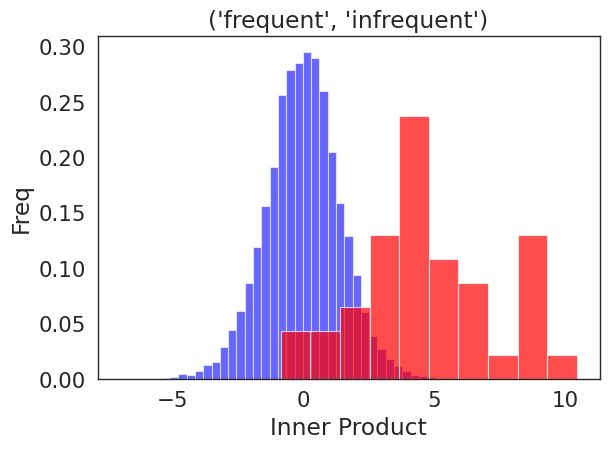

In [950]:
# this one is interesting = frequent/infrequent is about word frequency: 
# ['drink', 'beverage'],
# ['dry', 'arid'],
# ['end', 'terminate'],
# ['hot', 'sweltering']
# does this good separation imply that the model switches between different language styles (formal / informal / literature / casual) ?
k = ('frequent', 'infrequent')
fig1 = random_histogram(random_pairs_g, concept_g_orig[k], inner_prods_loo=causal_inner_prods_orig[k],  title=k)

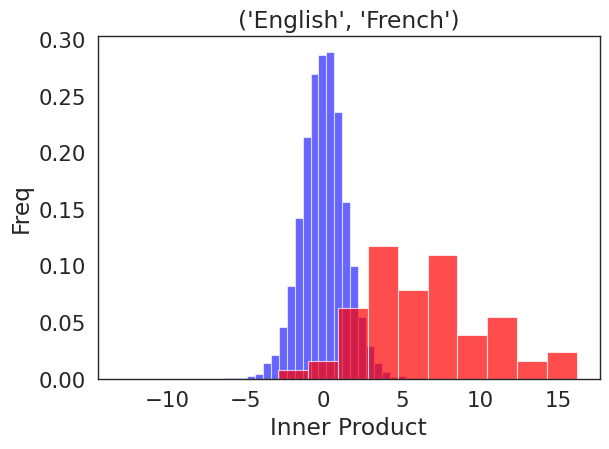

In [953]:
k = ('English', 'French')
fig2 = random_histogram(random_pairs_g, concept_g_orig[k], inner_prods_loo=causal_inner_prods_orig[k],  title=k)

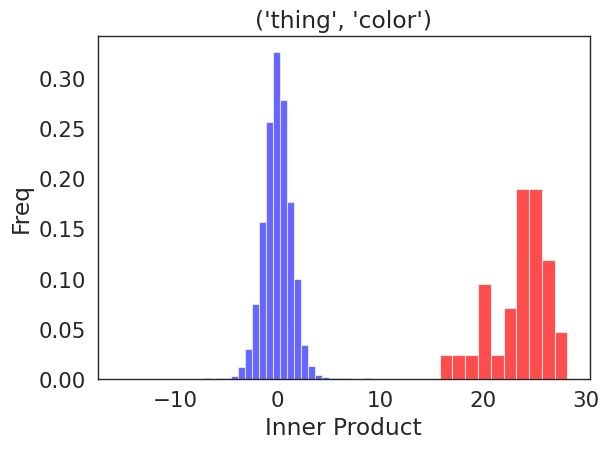

In [847]:
k = ('thing', 'color')
fig3 = random_histogram(random_pairs_g, concept_g_orig[k], inner_prods_loo=causal_inner_prods_orig[k],  title=k)
# nice?

Text(0, 0.5, 'small_big')

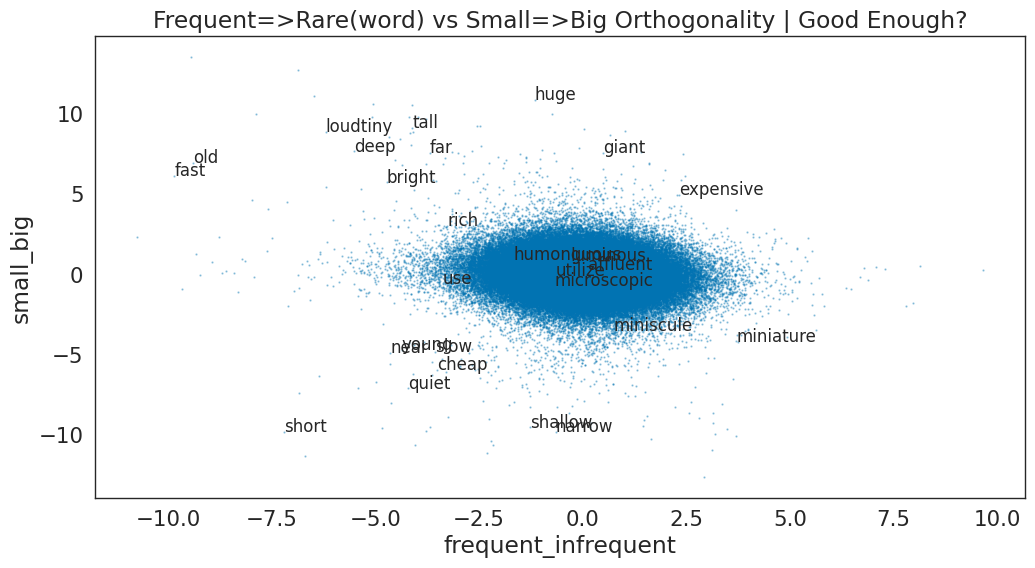

In [965]:
names = ['use', 'utilize', 'rich', 'affluent', 'bright', 'luminous', 'narrow', 'cheap', 'expensive',
        'young', 'old', 'near', 'far', 'shallow', 'deep',  'quiet', 'loud'
        'tiny', 'huge', 'slow', 'fast', 'short', 'tall', 'giant', 'miniature',
        'humonguous', 'miniscule', 'microscopic'
         ]
inds = [tokenizer.encode(word)[1] for word in names]


k1 = ('frequent','infrequent')
k2 = ('small', 'big')


a_g = g @ concept_g_orig[k1]
b_g = g @ concept_g_orig[k2]

fig, axs = plt.subplots(1, 1, figsize=(12,6))
plt.scatter(a_g.cpu(), b_g.cpu(), alpha = 0.3, s = 0.8)
for _, label in enumerate(names):
        axs.text(a_g[inds[_]], b_g[inds[_]], label, fontsize = 12)
plt.title('Frequent=>Rare(word) vs Small=>Big Orthogonality | Good Enough?')
plt.xlabel('_'.join(k1))
plt.ylabel('_'.join(k2))

# rarest words are often not so rare but rather just similar to what was types as "rare" in the training set (!)
# top_rarest_words = a_g.argsort()[-100:]
# tokenizer.convert_ids_to_tokens(top_rarest_words)

Text(0.5, 1.0, 'Male=>Female vs Eng=>French Orthogonality | Good Enough?')

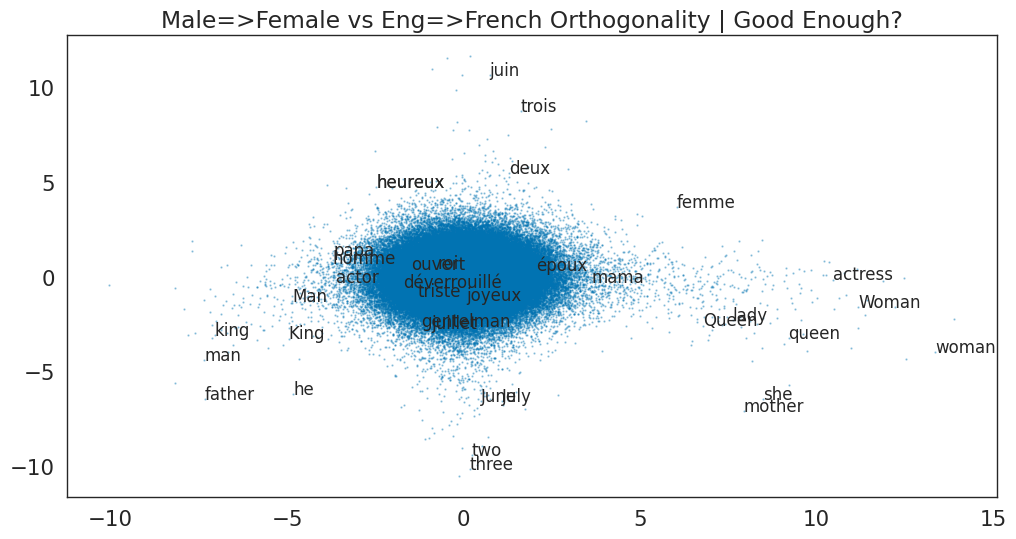

In [66]:
names = ["man", "woman", "king", "queen", "King", "Queen", "roi", "homme", "femme", "mama", "papa", "époux", 
        "actor", "actress", "Man", "Woman", "he", "she", "mother", "father", "lady", "gentelman",
        "deux", "two", "trois", "three", "July", "juillet", "June", "juin", 
        'heureux', 'joyeux', 'heureux', 'triste', 'ouvert', 'déverrouillé',]
inds = [tokenizer.encode(word)[1] for word in names]


k1 = ('male', 'female')
k2 = ('English', 'French')

a_g = g @ concept_g_orig[k1]
b_g = g @ concept_g_orig[k2]

fig, axs = plt.subplots(1, 1, figsize=(12,6))
plt.scatter(a_g.cpu(), b_g.cpu(), alpha = 0.3, s = 0.8)
for _, label in enumerate(names):
        axs.text(a_g[inds[_]], b_g[inds[_]], label, fontsize = 12)
plt.title('Male=>Female vs Eng=>French Orthogonality | Good Enough?')

The plot is pretty much the same, just skewed a bit!


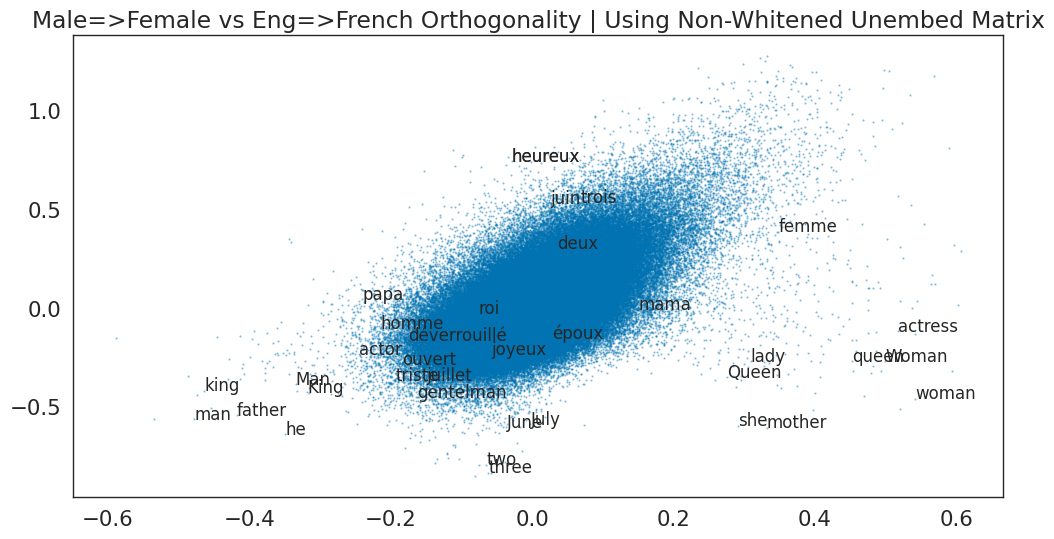

In [1201]:
names = ["man", "woman", "king", "queen", "King", "Queen", "roi", "homme", "femme", "mama", "papa", "époux", 
        "actor", "actress", "Man", "Woman", "he", "she", "mother", "father", "lady", "gentelman",
        "deux", "two", "trois", "three", "July", "juillet", "June", "juin", 
        'heureux', 'joyeux', 'heureux', 'triste', 'ouvert', 'déverrouillé',]
inds = [tokenizer.encode(word)[1] for word in names]


k1 = ('male', 'female')
k2 = ('English', 'French')

a_g = centered_unembed @ concept_g_orig[k1]
b_g = centered_unembed @ concept_g_orig[k2]

fig, axs = plt.subplots(1, 1, figsize=(12,6))
plt.scatter(a_g.cpu(), b_g.cpu(), alpha = 0.3, s = 0.8)
for _, label in enumerate(names):
        axs.text(a_g[inds[_]], b_g[inds[_]], label, fontsize = 12)
plt.title('Male=>Female vs Eng=>French Orthogonality | Using Non-Whitened Unembed Matrix')
print('The plot is pretty much the same, just skewed a bit!')

In [3]:
# Gemma with RotatE is hard to refactor!
model = HookedTransformer.from_pretrained(
    "google/gemma-2b",
    center_unembed=True,
    center_writing_weights=True,
    # fold_ln=True,
    # refactor_factored_attn_matrices=True,
)
# Get the default device used
device: torch.device = utils.get_device()

`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loaded pretrained model google/gemma-2b into HookedTransformer


In [ ]:
pre_logits = None

def capture_activations(module, input, output):
    global pre_logits
    pre_logits = output

hook_handle = model.ln_final.register_forward_hook(capture_activations)

model.tokenizer.padding_side = 'left'
tokens = model.to_tokens(concepts, prepend_bos=True)
model(tokens)

pre_logits_f = pre_logits[:, -1, :]
hook_handle.remove()

In [ ]:
# I thought the hook of `ln_final` would give us already normalized vectors???
pre_logits_f.sum(dim=1)

tensor([109.6046, 103.8795,  78.3074,  52.9044, 117.0146,  81.7069, 100.5760,
         52.5828], device='mps:0')

In [ ]:
cos_sim = (stacked_concept_vecs / stacked_concept_vecs.norm(dim=1, keepdim=True)) @ (pre_logits_f  / pre_logits_f.norm(dim=1, keepdim=True)).T

In [ ]:
df = pd.DataFrame(cos_sim.cpu())
df.columns = concepts
df.index = ["_".join(k) for k in concept_g_orig.keys()]

In [ ]:
df.idxmax()

gender         thing_color
translation    thing_color
size            thing_part
vertical       thing_color
frequency      thing_color
color          thing_color
inclusion      thing_color
plurality      thing_color
comparative     thing_part
superlative      small_big
dtype: object

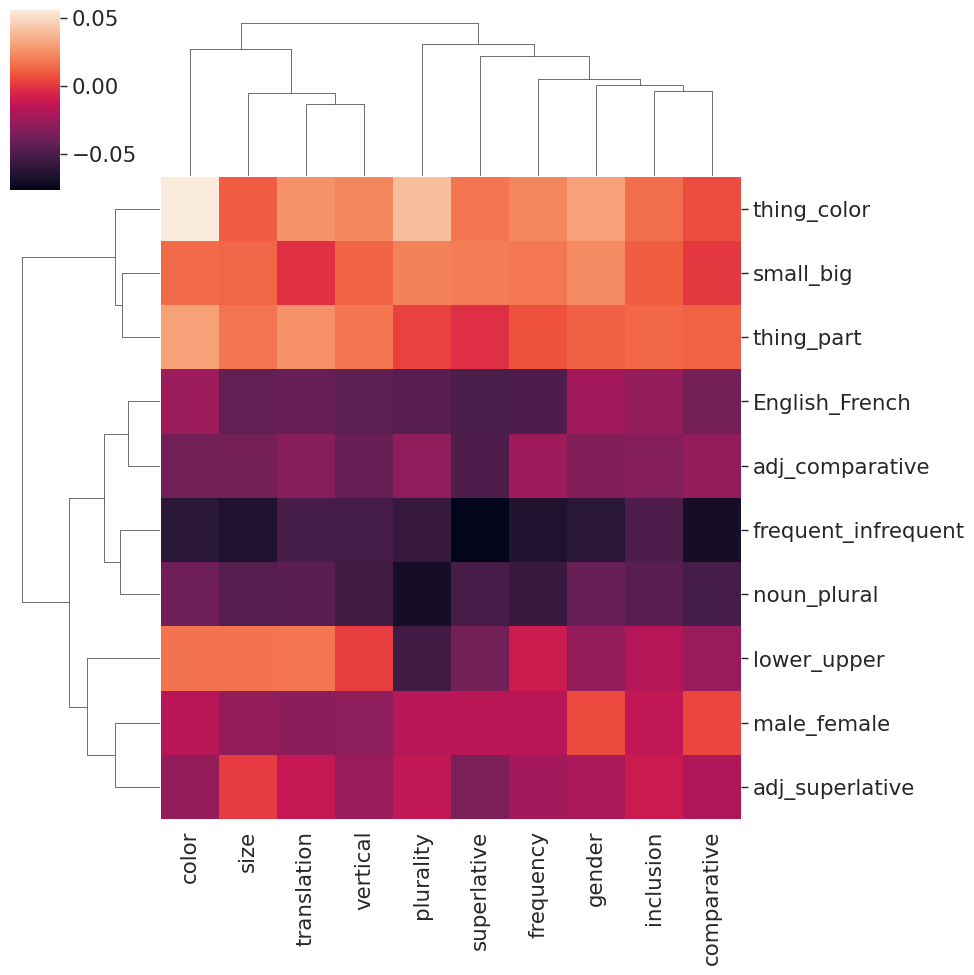

In [ ]:
# actually lower-upper is about Uppercase not position
# and frequent-infrequent is about word frequency, not temporal frequency!
sns.clustermap(df)

In [96]:
# hook function to capture the output before right unembedding
def capture_activations(module, input, output):
        global pre_logits
        pre_logits = output

### Control by adding the Concept Vector to pre-logits

In [71]:
# Note that we have removed "training" data from the "test" set that originally was 102 words
# english_french_pairs = [tp for tp in english_french_pairs if tp[0] not in [w[0].lower() for w in all_words_pairs[('English', 'French')]]]
english_french_test = counterfact_word_pairs_store['test']['eng_french']
english_french_test[:5]

[['earth', 'terre'],
 ['dew', 'rosée'],
 ['fog', 'brouillard'],
 ['flint', 'silex'],
 ['wood', 'bois']]

In [474]:
def generate_prompt_binary(counterfactual_pair, connector: str = ' ='):
    prompt = counterfactual_pair[0] + connector
    answer = counterfactual_pair[1]
    return prompt, answer

generate_prompt_binary(english_french_test[6])

('belt =', 'ceinture')

In [475]:
def get_rank(tensor, value_index):
    sorted_indices = torch.argsort(tensor.squeeze(0), descending=True)
    # Find the rank of the value by locating its index in the sorted indices
    rank = (sorted_indices == value_index).nonzero(as_tuple=True)[0].item() + 1
    return rank

In [476]:
txt = 'Transantlantic Railway System'
prompt = 'Transantlantic'
answer = ' Railway System'
assert prompt+answer == txt

logits_txt = model(txt)
logits_prompt = model(prompt)

torch.allclose(logits_txt[:,:5, :], logits_prompt)
torch.allclose(logits_txt[:, logits_prompt.shape[1]-1, :], logits_prompt[:, -1, :])

True

In [689]:
model.ln_final

RMSNormPre(
  (hook_scale): HookPoint()
  (hook_normalized): HookPoint()
)

In [1198]:
def compute_rank_difference(counterfact_pair, concept_vector, betas, connector=' =', print_all=True, sanity_check=False, return_stats=False):
    prompt, answer = generate_prompt_binary(counterfact_pair, connector)
    
    if print_all:
        print('prompt:', prompt)
        print('expected answer:', answer)

    prompt_toks = model.to_tokens(prompt, prepend_bos=True)
    answer_toks = model.to_tokens(answer, prepend_bos=False)

    answer_toks = answer_toks[:,0] # take first token of the answer

    # Hook function to capture the output before right unembedding
    pre_logits = None
    def capture_activations(module, input, output):
        nonlocal pre_logits
        pre_logits = output

    # Register the hook on the final layer ('ln_final' for GPT-2 and Gemma)
    hook_handle = model.ln_final.register_forward_hook(capture_activations)

    # Generate logits
    logits = model(prompt_toks)[:, prompt_toks.shape[1]-1, :]
    
    original_logit = logits[:, answer_toks].item()
    original_rank = get_rank(logits, answer_toks.item())
    
    if print_all:
        print('expected answer original logit:', original_logit)
        print('expected answer original rank:', original_rank)
        print('top-1 pred orig:', model.to_string(logits.argmax()))

    # we ran for many betas to avoid re-running model 
    collect_ranks = []
    stats = []
    pre_logits_f = pre_logits[:, -1, :]
    # pre_logits_f = pre_logits_f @ sqrt_Cov_gamma
    for beta in betas:
         # Modify the logits with the concept vector
        trans_pre_logits_f = pre_logits_f + beta * concept_vector.unsqueeze(0)
        # Remove the hook after capturing the necessary activations
        hook_handle.remove()

        # Generate transformed logits
        # model.unembed(model.ln_final(trans_pre_logits_f))
        # model.unembed(model.ln_final.hook_normalized(trans_pre_logits_f))
        # g @ model.ln_final.hook_normalized(trans_pre_logits_f).T
        # trans_logits = g @ trans_pre_logits_f.T
        trans_logits = model.unembed(model.ln_final.hook_normalized(trans_pre_logits_f))
        
        # print(trans_logits.shape)
        trans_logits = trans_logits.squeeze()
        perturbed_logit = trans_logits[answer_toks].item()
        perturbed_rank = get_rank(trans_logits, answer_toks.item())
        rank_diff = original_rank - perturbed_rank
        collect_ranks.append(rank_diff)

        if return_stats:
            stats.append({'original_rank':original_rank, 'perturbed_rank':perturbed_rank,
                    'original_output': model.to_string(logits.argmax()),
                    'perturbed_output':model.to_string(trans_logits.argmax()),
                    'rank_diff': rank_diff,
                    'beta': beta})

    if len(betas) == 1 and print_all:
        print('expected answer perturbed logit:', perturbed_logit)
        print('expected answer perturbed rank:', perturbed_rank)
        print('top-1 pred perturb:', model.to_string(trans_logits.argmax()))
    
    if len(betas) == 1 and sanity_check:
        assert torch.allclose(trans_pre_logits_f.squeeze() - pre_logits_f.squeeze(), concept_vector.unsqueeze(0), rtol=0.001)
        print('Pre-Logits distance: ', (trans_pre_logits_f-pre_logits_f).norm().item())
        print('Perturbed Logits equal to original Logits: ', torch.allclose(logits, trans_logits, rtol=0.01))
        print('Perturbed best token equal to orig best tok: ', torch.allclose(logits.argmax(), trans_logits.argmax(), rtol=0.001))


    if return_stats:
        return stats
    # Return the decrease in rank (where rank=1 is the largest logit) for each of beta 
    return collect_ranks

In [1193]:
k = ('English', 'French')
betas = [-5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 5, 8, 10, 20, 30, 100, 500]

train_word_pairs = all_words_pairs[k]
test_word_pairs = english_french_test
cocept_vector = concept_g_orig[k]

def compare_concept_steering(train_word_pairs, test_word_pairs, cocept_vector, betas):
    rank_decreases_train = []
    rank_decreases_test = []
    # run on "train data" - on which original concept vector is computed
    for word_pair in tqdm(train_word_pairs):
        rank_decrease = compute_rank_difference(word_pair, cocept_vector, betas=betas, print_all=False)
        rank_decreases_train.append(rank_decrease)

    # run on "test data" - counterfactual pairs not included in `concept_w` calc
    for word_pair in tqdm(test_word_pairs):
        rank_decrease = compute_rank_difference(word_pair, cocept_vector, betas=betas, print_all=False)
        rank_decreases_test.append(rank_decrease)
    
    df_train = pd.DataFrame(torch.Tensor(rank_decreases_train).cpu(), columns=betas, index=["_".join(w) for w in train_word_pairs])
    df_test = pd.DataFrame(torch.Tensor(rank_decreases_test).cpu(), columns=betas, index=["_".join(w) for w in test_word_pairs])

    df_train['train'] = True
    df_test['train'] = False
    dff = pd.concat([df_train, df_test], axis=0)
    dff['num_toks_answer'] = [model.to_tokens(w.split('_'), prepend_bos=False).shape[1] for w in dff.index]
    return dff 

dff = compare_concept_steering(train_word_pairs, test_word_pairs, cocept_vector, betas)

100%|██████████| 66/66 [00:13<00:00,  4.97it/s]


In [527]:
# postive = rank decrease = "good"
dff[dff['train']].mean(axis=0)

-5.0              -26319.568359
-1.0               -3827.603516
-0.5               -1679.327637
0.0                    0.000000
0.5                 1233.224121
1.0                 2056.836182
1.5                 2535.241455
2.0                 2737.543213
5.0                 -119.491379
8.0                -7581.457031
10.0              -13364.232422
20.0              -34180.621094
30.0              -42875.414062
100.0             -53304.984375
500.0             -56368.179688
train                  1.000000
num_toks_answer        1.474138
dtype: float64

In [528]:
# for test we see even detrimental impact on the rank!
dff[~dff['train']].mean(axis=0)

-5.0               -6547.696777
-1.0                 418.212128
-0.5                 365.848480
0.0                   -0.015152
0.5                 -658.136353
1.0                -1585.439453
1.5                -2786.105957
2.0                -4245.575684
5.0               -17080.818359
8.0               -31928.621094
10.0              -41159.652344
20.0              -70497.625000
30.0              -80326.164062
100.0             -90043.851562
500.0             -92798.304688
train                  0.000000
num_toks_answer        1.696970
dtype: float64

In [496]:
# but this is simply due to 2+ token words over-represented in test compated to train
pd.crosstab(dff['train'], dff['num_toks_answer'])

num_toks_answer,1,2,3
train,,,
False,26,34,6
True,68,41,7


In [499]:
# restricting only to 1 tok words we get strong positive impact for test
dff[(~dff['train']) & (dff['num_toks_answer']==1)].mean(axis=0)

-5.0              -37632.269531
-1.0               -6410.384766
-0.5               -3061.576904
0.0                   -0.038462
0.5                 2811.961426
1.0                 5398.922852
1.5                 7746.346191
2.0                 9832.692383
5.0                16888.500000
8.0                18480.115234
10.0               18552.691406
20.0               16471.884766
30.0               14382.769531
100.0               7871.230957
500.0               4645.769043
train                  0.000000
num_toks_answer        1.000000
dtype: float64

In [500]:
# clearly two-token+  words screw us up quite a bit!
# the actual challenge would be to generalize to multi-token perplexity compute vs logit rank
# this can be done by considering cumulative perplexity but it is not clear how to average across multiple tokens
# just taking the mean is wrong because in-word tokens must have much higher perplexity than the first word
dff.groupby('num_toks_answer').agg(lambda x: round(sum(x)/len(x)))

,-5.0,-1.0,-0.5,0.0,0.5,1.0,1.5,2.0,5.0,8.0,10.0,20.0,30.0,100.0,500.0,train
num_toks_answer,,,,,,,,,,,,,,,,
1,-50976,-9217,-4357,0,3875,7303,10344,13042,23369,25735,25205,20777,17258,9676,6522,1
2,18657,5969,3146,0,-3432,-7120,-11044,-15140,-41117,-64786,-78485,-119527,-132795,-145297,-148132,1
3,-7129,182,226,0,-553,-1428,-2598,-4083,-19542,-42068,-57668,-123565,-149052,-164503,-166659,1


In [510]:
# we see saturation when growring Beta - probably due to normalization action on tokens
dff

,-5.0,-1.0,-0.5,0.0,0.5,1.0,1.5,2.0,5.0,8.0,10.0,20.0,30.0,100.0,500.0,train,num_toks_answer
April_avril,-145207.0,-41225.0,-19608.0,0.0,15775.0,28223.0,38259.0,46656.0,78737.0,83870.0,84201.0,84344.0,84338.0,84285.0,84236.0,True,1
August_août,-75501.0,-30874.0,-17365.0,0.0,21103.0,44452.0,66852.0,86196.0,145437.0,169435.0,172132.0,173435.0,173509.0,173546.0,173530.0,True,1
December_décembre,14754.0,4691.0,2466.0,0.0,-2595.0,-5175.0,-7739.0,-10348.0,-24525.0,-36344.0,-43524.0,-74268.0,-97854.0,-136778.0,-149696.0,True,2
February_février,13080.0,3945.0,2072.0,1.0,-2179.0,-4419.0,-6637.0,-8971.0,-21504.0,-32412.0,-38694.0,-65015.0,-83470.0,-116597.0,-128765.0,True,2
January_janvier,2359.0,918.0,508.0,0.0,-669.0,-1515.0,-2635.0,-4126.0,-22702.0,-44063.0,-55846.0,-101932.0,-144531.0,-214870.0,-230224.0,True,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
hand_main,17604.0,6715.0,3698.0,0.0,-4444.0,-9663.0,-15656.0,-22530.0,-73259.0,-130992.0,-167106.0,-225582.0,-231638.0,-233770.0,-233901.0,False,1
cherry_cerise,59406.0,15334.0,7809.0,0.0,-8055.0,-16072.0,-24327.0,-32394.0,-75676.0,-108219.0,-123903.0,-147699.0,-152648.0,-155756.0,-155957.0,False,2
heart_cœur,1468.0,577.0,322.0,0.0,-401.0,-930.0,-1617.0,-2514.0,-17589.0,-48793.0,-71283.0,-185230.0,-231922.0,-251903.0,-252869.0,False,2
leaf_feuille,-80667.0,-8773.0,-3964.0,1.0,3393.0,6329.0,8927.0,11242.0,20277.0,23502.0,24160.0,23994.0,23256.0,21138.0,19878.0,False,1


In [576]:
px.box(dff[(~dff['train'])].sort_values(by='num_toks_answer')[[1.0, 1.5, 2.0, 5.0, 8.0, 10.0]].T, title='positive rank difference, English -> French, test set word pairs') # 1.0, 1.5, 2.0, 5.0, 8.0, 10 betas

In [573]:
# soil - sol are probably too similar
# wind - vent ?
# hand - main ? 
# schoold - ecole related to apostrophe?
px.box(dff[(~dff['train']) & (dff['num_toks_answer']==1)][[1.0, 1.5, 2.0, 5.0, 8.0,	10.0]].T, title='positive rank difference, English -> French, test set word pairs') # 1.0, 1.5, 2.0, 5.0, 8.0, 10 betas

In [523]:
dff2 = dff[dff['num_toks_answer']==1]
px.box(dff2 / dff2.abs().max(axis=0), color='train')

In [72]:
object_color_test = [
    ('sky', 'blue'),
    ('coal', 'black'),
    ('snow', 'white'),
    ('carrot', 'orange'),
    ('cherry', 'red'),
    ('grass', 'green'),
    ('sun', 'yellow'),
    ('rose', 'red'),
    ('blueberry', 'blue'),
    ('tomato', 'red'),
    ('milk', 'white'),
    ('emerald', 'green'),
    ('cucumber', 'green'),
    ('blood', 'red'),
    ('coal', 'black'),
    ('sapphire', 'blue'),
    ('ruby', 'red'),
    ('chocolate', 'brown'),
    ('basalt', 'black')]


object_color_test = counterfact_word_pairs_store['test']['obj_color']
object_color_test[:5]
# object_color_tests = [tp for tp in object_color_test if tp[0] not in [w[0].lower() for w in all_words_pairs[('thing', 'color')]]]

[['sky', 'blue'],
 ['coal', 'black'],
 ['snow', 'white'],
 ['carrot', 'orange'],
 ['cherry', 'red']]

In [1196]:
k = ('thing', 'color')
train_word_pairs = all_words_pairs[k]
test_word_pairs = object_color_test
cocept_vector = concept_g_orig[k]

dff = compare_concept_steering(train_word_pairs, test_word_pairs, cocept_vector, betas)

100%|██████████| 19/19 [00:03<00:00,  4.91it/s]


In [552]:
dff.groupby('num_toks_answer').agg(lambda x: round(sum(x)/len(x)))

,-5.0,-1.0,-0.5,0.0,0.5,1.0,1.5,2.0,5.0,8.0,10.0,20.0,30.0,100.0,500.0,train
num_toks_answer,,,,,,,,,,,,,,,,
1,-219909,-34676,-14185,0,8833,13926,16664,18073,19387,19415,19417,19418,19419,19419,19420,1
2,-210759,-28486,-11496,0,7044,11037,13112,14135,15050,15071,15072,15074,15074,15075,15075,1
3,-231239,-43172,-17185,0,10187,15596,18228,19335,20100,20109,20109,20112,20113,20113,20113,1


In [554]:
pd.crosstab(dff['train'], dff['num_toks_answer'])

num_toks_answer,1,2,3
train,,,
False,16,3,0
True,34,15,1


In [563]:
num_toks_eng = [model.to_tokens(w[0], prepend_bos=False).shape[1] for w in (all_words_pairs[('English', 'French')] + english_french_test)]
num_toks_fr = [model.to_tokens(w[1], prepend_bos=False).shape[1] for w in (all_words_pairs[('English', 'French')] + english_french_test)]

In [564]:
pd.crosstab(num_toks_eng + num_toks_fr, ['eng']*len(num_toks_eng) + ['fr']*len(num_toks_fr))

col_0,eng,fr
row_0,,
1,167,95
2,13,75
3,2,12


In [577]:
k = ('English', 'French')
betas = [-5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 5, 8, 10, 20, 30, 100, 500]

train_word_pairs = all_words_pairs[k]
test_word_pairs = english_french_test
cocept_vector = concept_g_orig[k]

train_word_pairs = [tp[::-1] for tp in train_word_pairs]
test_word_pairs = [tp[::-1] for tp in test_word_pairs]
 
dff = compare_concept_steering(train_word_pairs, test_word_pairs, -cocept_vector, betas) # dont forget minus for concept vector

100%|██████████| 66/66 [00:12<00:00,  5.22it/s]


In [578]:
# and we get much better results than for english -> french!
dff.groupby('num_toks_answer').agg(lambda x: round(sum(x)/len(x)))

,-5.0,-1.0,-0.5,0.0,0.5,1.0,1.5,2.0,5.0,8.0,10.0,20.0,30.0,100.0,500.0,train
num_toks_answer,,,,,,,,,,,,,,,,
1,-78419,-9388,-4272,0,3520,6381,8692,10539,16009,17540,17924,18254,18078,16473,15319,1
2,-46795,-6192,-2880,0,2472,4581,6365,7866,12910,14376,14511,12660,10688,5065,1753,1
3,-35636,-4338,-2031,0,1803,3378,4698,5839,9760,11126,11430,9945,6579,-3664,-8656,1


In [580]:
px.box(dff[(~dff['train'])].sort_values(by='num_toks_answer')[[1.0, 1.5, 2.0, 5.0, 8.0,	10.0]].T, title='positive rank difference, French -> English, test set word pairs') # 1.0, 1.5, 2.0, 5.0, 8.0, 10 betas

In [73]:
objects_material_train = counterfact_word_pairs_store['train']['obj_material']
objects_material_test = counterfact_word_pairs_store['test']['obj_material']
objects_material_train[:5]

[['table', 'wood'],
 ['bottle', 'glass'],
 ['knife', 'steel'],
 ['shirt', 'cotton'],
 ['window', 'glass']]

In [596]:
_, concept_material, *_ = generate_concept_direction(unembed=unembedding_matrix, rot_unembed=g, words_pairs=objects_material_train)

In [598]:
k = ('Object', 'Material')
betas = [-5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 5, 8, 10, 20, 30, 100, 500]

dff = compare_concept_steering(objects_material_train, objects_material_test, concept_material, betas) # dont forget minus for concept vector

100%|██████████| 15/15 [00:02<00:00,  5.08it/s]


In [599]:
# and we get much better results than for english -> french!
dff.groupby('num_toks_answer').agg(lambda x: round(sum(x)/len(x)))

,-5.0,-1.0,-0.5,0.0,0.5,1.0,1.5,2.0,5.0,8.0,10.0,20.0,30.0,100.0,500.0,train
num_toks_answer,,,,,,,,,,,,,,,,
1,-139701,-33828,-16041,0,13740,25047,34027,41033,59580,63670,64558,65639,65808,65805,65708,1
2,-86033,-19196,-9327,0,8463,15725,21703,26479,38462,39559,39153,35863,33120,24705,20636,1
3,-114,4,-6,0,4,-8,-34,-56,-247,-639,-1003,-4207,-9982,-65100,-122744,1


In [600]:
pd.crosstab(dff['train'], dff['num_toks_answer'])

num_toks_answer,1,2,3
train,,,
False,7,8,0
True,63,25,1


In [610]:
dff

,-5.0,-1.0,-0.5,0.0,0.5,1.0,1.5,2.0,5.0,8.0,10.0,20.0,30.0,100.0,500.0,train,num_toks_answer
table_wood,-140336.0,-66251.0,-35590.0,0.0,34320.0,61166.0,80206.0,92976.0,112341.0,112696.0,112703.0,112705.0,112705.0,112705.0,112705.0,True,1
bottle_glass,-122313.0,-11194.0,-5068.0,0.0,4055.0,7150.0,9535.0,11255.0,14744.0,14984.0,15004.0,15010.0,15009.0,15011.0,15012.0,True,1
knife_steel,-118320.0,-45666.0,-24359.0,0.0,24636.0,47755.0,67378.0,83224.0,125071.0,129622.0,129790.0,129830.0,129833.0,129838.0,129840.0,True,1
shirt_cotton,-106160.0,-26396.0,-13179.0,0.0,12673.0,24499.0,35378.0,45273.0,83264.0,97539.0,100709.0,102578.0,102623.0,102638.0,102641.0,True,1
window_glass,-125990.0,-34926.0,-17368.0,0.0,16576.0,31748.0,44677.0,55868.0,91177.0,98864.0,99550.0,99757.0,99762.0,99768.0,99769.0,True,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
towel_cotton,-115520.0,-17568.0,-8220.0,0.0,7254.0,13489.0,18894.0,23454.0,39179.0,43462.0,44147.0,44558.0,44566.0,44568.0,44567.0,False,2
notebook_paper,-113501.0,-17356.0,-8161.0,0.0,7163.0,13350.0,18669.0,23275.0,39750.0,45111.0,46095.0,46648.0,46650.0,46644.0,46641.0,False,1
chest_wood,-213401.0,-50545.0,-20941.0,0.0,14312.0,23771.0,29457.0,32583.0,35385.0,35406.0,35407.0,35409.0,35409.0,35409.0,35409.0,False,1
curtain_fabric,-22296.0,-3367.0,-1629.0,0.0,1548.0,2900.0,4228.0,5520.0,11156.0,14491.0,15950.0,18423.0,18747.0,18522.0,17921.0,False,2


In [601]:
# It is very surprising how well it works given that 
px.box(dff[(~dff['train'])].sort_values(by='num_toks_answer')[[1.0, 1.5, 2.0, 5.0, 8.0,	10.0]].T, title='positive rank difference, Object -> Material, test set word pairs')

In [692]:
betas = [0,1,2,3,4,5,6,7,8,9,10,15,20,30,50,100]
all_stats = []
for word_pair in objects_material_test:
    for beta in betas:
        res = compute_rank_difference(word_pair, concept_material, connector='=', betas=[beta], print_all=False, return_stats=True)
        res['beta'] = beta
        res['word_pair'] = "_".join(word_pair)
        all_stats.append(res)

In [691]:
compute_rank_difference(('curtain', 'fabric'), concept_material, connector='=', betas=[10], print_all=False, return_stats=True)

{'original_rank': 1065,
 'perturbed_rank': 187,
 'original_output': 'input',
 'perturbed_output': 'metal'}

In [693]:
df = pd.DataFrame(all_stats)

In [720]:
px.line(df[df['beta']<40], x='beta', y='perturbed_rank', color='word_pair', markers='<>', title='Answer Rank Decrease (1=best) after adding `beta*material_concept_vec` to pre-logits')

In [724]:
from collections import Counter
# badly performing materials are not present in the "train set" 
CC = Counter([w[1] for w in objects_material_train])
print(CC.get('feathers'))
print(CC.get('straw'))
print(CC.get('linen'))

print(CC.get('rubber'))
print(CC.get('concrete'))
print(CC.get('stainless steel'))

None
None
None
1
1
1


In [728]:
df['perturbed_output'].value_counts()

perturbed_output
wood        133
input        51
metal        25
0            13
int           7
function      5
1             5
require       1
Name: count, dtype: int64

In [719]:
px.line(df[(df['beta']<10)&(df['original_rank']<5000)], x='beta', y='perturbed_rank', color='word_pair', markers='<>', log_x=True, log_y=True, title='Answer Rank Decrease (1=best) after adding `beta*material_concept_vec` to pre-logits')

In [74]:
object_part_test = counterfact_word_pairs_store['test']['object_part']
object_part_test[:5]

[['lamp', 'shade'],
 ['boot', 'heel'],
 ['broom', 'handle'],
 ['book', 'page'],
 ['tree', 'branch']]

In [806]:
# lets try to run Thing -> Part forward vs reverse
k = ('thing', 'part')
betas = [-5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 5, 8, 10, 20, 30, 100, 500]

train_word_pairs = all_words_pairs[k]
test_word_pairs = object_part_test
cocept_vector = concept_g_orig[k]
 
dff = compare_concept_steering([], test_word_pairs, cocept_vector, betas) # dont forget minus for concept vector

100%|██████████| 24/24 [00:04<00:00,  5.26it/s]


In [809]:
beta = 5 # beta=5 is optimal in most cases 
object_to_part = dff[(~dff['train'])].sort_values(by='num_toks_answer')[beta].T

In [822]:
# train_word_pairs = [tp[::-1] for tp in all_words_pairs[k]]
# test_word_pairs = [tp[::-1] for tp in test_word_pairs]
 
dff = compare_concept_steering([], test_word_pairs, -cocept_vector, betas) # dont forget minus for concept vector

part_to_object = dff[(~dff['train'])].sort_values(by='num_toks_answer')[beta].T

100%|██████████| 24/24 [00:04<00:00,  5.14it/s]


In [825]:
df = pd.DataFrame(object_to_part)
df.columns = ['direct']
df['inverse'] = part_to_object.values
px.bar(df, barmode='group', title='Rank Decrease for Thing -> Part vs Part -> Thing')

In [778]:
dff2 = dff[dff['num_toks_answer']==1].iloc[:,3:]
px.box(dff2 / dff2.abs().max(axis=0), color='train', title='positive rank difference, Part -> Thing, Train pairs (blue) | Test pairs (red)')

### Going deeper into the model

In [949]:
list(concept_g_orig.keys())

[('male', 'female'),
 ('English', 'French'),
 ('small', 'big'),
 ('lower', 'upper'),
 ('frequent', 'infrequent'),
 ('thing', 'color'),
 ('thing', 'part'),
 ('noun', 'plural'),
 ('adj', 'comparative'),
 ('adj', 'superlative')]

In [984]:
# lets check incrementally "bigger" objects according to the "small-big" concept
# micro, mini, minor, small, average, broad, big, large, giant, huge, immense, gigantic, enormous, colossal, mammoth, 
k = ('small', 'big')
compute_rank_difference(counterfact_pair=('average', 'small'), concept_vector=concept_g_orig[k], betas=[-10], return_stats=True, connector=' or')

prompt: average or
expected answer: small
expected answer original logit: 2.349363327026367
expected answer original rank: 71463
top-1 pred orig:  mean
expected answer perturbed logit: 11.27486801147461
expected answer perturbed rank: 262
top-1 pred perturb:  small


{'original_rank': 71463,
 'perturbed_rank': 262,
 'original_output': ' mean',
 'perturbed_output': ' small'}

In [1036]:
def _find_beta_changes(df):
    df = df.sort_values(by='beta').reset_index(drop=True)
    changes = df['perturbed_output'].ne(df['perturbed_output'].shift()).astype(int)
    boundaries = df['beta'][changes == 1].tolist()
    return boundaries

def polynomial_space(start, stop, num, power=2.0):
    linear_space = np.linspace(0, 1, num)
    nonlinear_space = np.power(linear_space, power)
    return start + (stop - start) * nonlinear_space

In [1151]:
center_words = ['micro', 'mini', 'short', 'average', 'normal', 'enormous', 'Moon', 'Sun', 'house', 'mouse', 'pebble']
outputs = {}

# we scan pre-logit space with beta varying from -300 to +300 and starting from differen "center" words 
# this is for the concept_vectors allegedly describing size concept
for word in center_words:
    stats = compute_rank_difference(counterfact_pair=(word, 'small'), concept_vector=concept_g_orig[k], betas=polynomial_space(-200, 200, 1000), 
                                print_all=False, return_stats=True, connector=',')
    df = pd.DataFrame(stats)
    beta_bounds = _find_beta_changes(df)
    switching_words = df['perturbed_output'].unique()
    outputs[word] = {'beta_bounds':beta_bounds, 'switching_words':switching_words}

In [1152]:
def plot_word_change(beta_values, words, runs, labels, figsize=(30, 10)):
    """
    Plots horizontal bar plots stacked vertically showing word changes as beta varies.
    """
    xlim0 = -45
    xlim1 = 45
    fig, axs = plt.subplots(runs, 1, figsize=figsize, sharex=True)
    for i in range(runs):
        ax = axs[i]

        # Plot each word's section as a bar
        for j in range(len(beta_values[i])-1):
            start, end = beta_values[i][j], beta_values[i][j+1]
            word = words[i][j]
            if word.strip() in labels[i]:
                color = 'green'
            else:
                color = 'royalblue'
            ax.barh(i, end - start, left=start, height=0.2, color=color, edgecolor='black')
            ax.text((max(start, xlim0) + min(end, xlim1)) / 2, i, word, ha='center', va='center', fontsize=15, color='white')
        ax.barh(i, 10, left=xlim1, height=0.2, color='white', edgecolor='black')
        ax.text(xlim1+3, i, labels[i], ha='center', va='center', fontsize=18, color='black')


        # Set y-axis to hide labels, only showing word bars
        ax.set_yticks([])
        ax.set_xlim(xlim0, xlim1)
    axs[0].set_title('Adding Size-Concept vector multiplied by Beta to different initial words (shown on the right for each bar)', size=20)
    plt.xlabel('Beta')
    plt.tight_layout()
    plt.show()

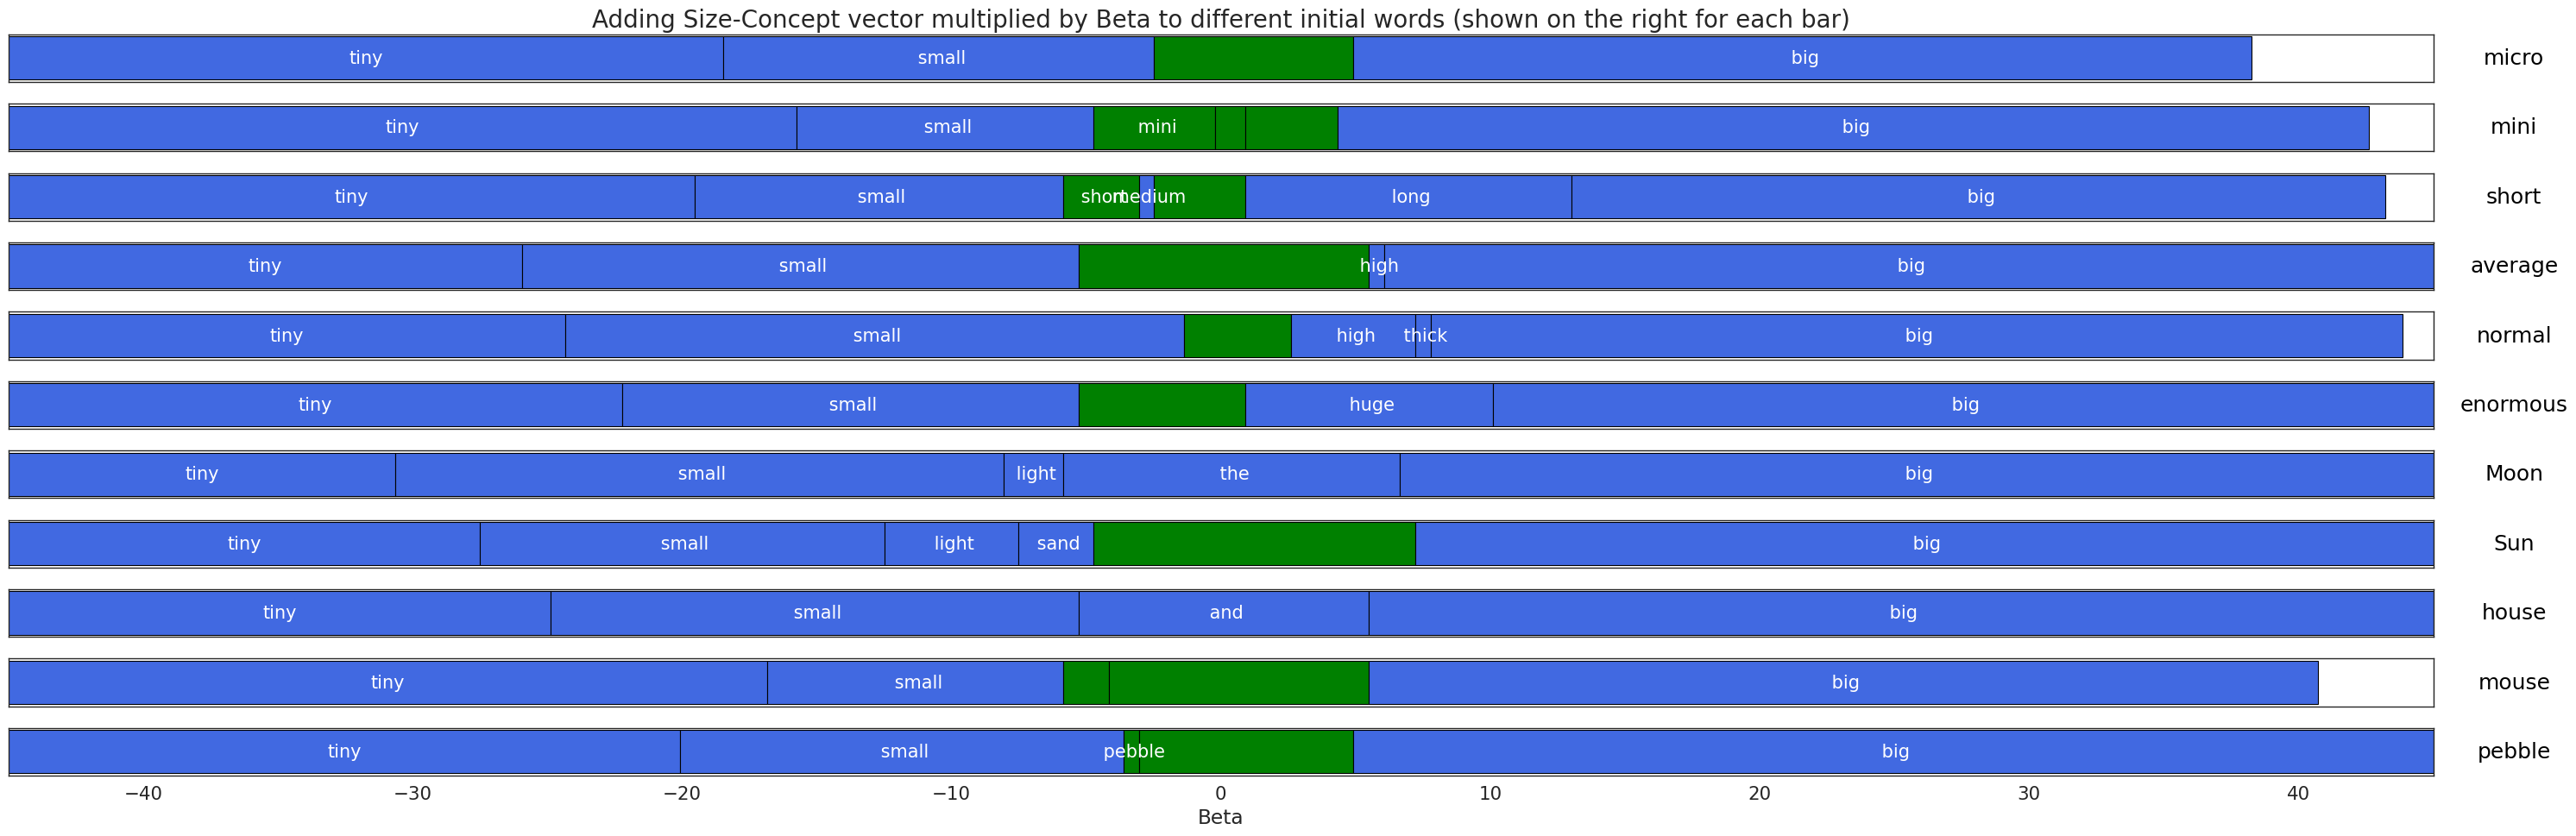

In [1153]:
plot_word_change([v['beta_bounds'] for v in outputs.values()], [v['switching_words'] for v in outputs.values()], len(center_words), labels=list(outputs.keys()))


In [1025]:
stats = compute_rank_difference(counterfact_pair=('Moon', 'small'), concept_vector=concept_g_orig[k], betas=np.linspace(-100, 100, 1000), 
                                print_all=False, return_stats=True, connector=' or')
pd.DataFrame(stats)['perturbed_output'].unique()

array(['tiny', ' Shallow', ' small', ' light', ' sun', ' Sun', ' big',
       'big'], dtype=object)

In [388]:
# example_prompt = "There is a fine line between stupid and... "
utils.test_prompt('Switch the gender of the word: actor:actress,  wife:', 'husband', model, prepend_bos=True)

Tokenized prompt: ['<bos>', 'Switch', ' the', ' gender', ' of', ' the', ' word', ':', ' actor', ':', 'actress', ',', '  ', 'wife', ':']
Tokenized answer: [' husband']


Performance on answer token:
Rank: 1        Logit: 18.53 Prob: 13.32% Token: | husband|

Top 0th token. Logit: 19.93 Prob: 53.73% Token: |husband|
Top 1th token. Logit: 18.53 Prob: 13.32% Token: | husband|
Top 2th token. Logit: 18.11 Prob:  8.73% Token: |wife|
Top 3th token. Logit: 16.64 Prob:  2.01% Token: | ________|
Top 4th token. Logit: 16.32 Prob:  1.46% Token: |<strong>|
Top 5th token. Logit: 16.29 Prob:  1.41% Token: | wife|
Top 6th token. Logit: 16.27 Prob:  1.38% Token: | |
Top 7th token. Logit: 16.13 Prob:  1.20% Token: |______|
Top 8th token. Logit: 15.79 Prob:  0.85% Token: |____|
Top 9th token. Logit: 15.62 Prob:  0.72% Token: | ______|


Ranks of the answer tokens: [(' husband', 1)]

#### Going deeper into Transformer

In [ ]:
# original test
example_prompt = "There is a fine line between stupid and... "
example_answer = " clever"
utils.test_prompt(example_prompt, example_answer, model, prepend_bos=True)

Tokenized prompt: ['<bos>', 'There', ' is', ' a', ' fine', ' line', ' between', ' stupid', ' and', '...', ' ']
Tokenized answer: [' clever']


Performance on answer token:
Rank: 10724    Logit:  7.53 Prob:  0.00% Token: | clever|

Top 0th token. Logit: 23.27 Prob: 52.74% Token: |<em>|
Top 1th token. Logit: 22.25 Prob: 19.12% Token: |<i>|
Top 2th token. Logit: 21.96 Prob: 14.29% Token: |<strong>|
Top 3th token. Logit: 21.04 Prob:  5.69% Token: |<b>|
Top 4th token. Logit: 20.39 Prob:  2.96% Token: |

|
Top 5th token. Logit: 19.13 Prob:  0.84% Token: |1|
Top 6th token. Logit: 18.99 Prob:  0.73% Token: |
|
Top 7th token. Logit: 18.67 Prob:  0.53% Token: |5|
Top 8th token. Logit: 18.62 Prob:  0.51% Token: |2|
Top 9th token. Logit: 18.56 Prob:  0.48% Token: |<u>|


Ranks of the answer tokens: [(' clever', 10724)]

1. Concepts are like Predicates in KG
2. When we add the Concept's Vector we do `Head -[dir]-> Tail`  transition, hence we call first words in counterfact pairs `h` and second words `t` and the transition vector is `v` 
3. `Hypothesis 1`: adding Concept's Vector `v` to the pre-logits vec should move us to a Tail-Like concepts, if from context `c` we anticipated `h` - as in Word2Vec 
4. `Hypothesis 2`: chaining counterfactual pairs [(w11, w12), ...] as a long list should make predicted wn2 in the last (wn1, wn2) aligned with Concept's Vector
5. `Hypothesis 3`: given a single word `h` in a counterfactual pair + the Concept's vector `v` we should be able to predict something similar to the second word
6. `Hypothesis 4`: given a collection of words `h1,h2,..,h_n` from one side of counterfactual pairs + the Concept's vector `v` we should be able to predict smth similar to the `mean` of their pairs `t`

In [1208]:
utils.test_prompt("A:(blue plastic ball), B:(red wood square), C:(green metal triangle), A is", 'blue', model, prepend_bos=True, print_details=True)

Tokenized prompt: ['<bos>', 'A', ':(', 'blue', ' plastic', ' ball', '),', ' B', ':(', 'red', ' wood', ' square', '),', ' C', ':(', 'green', ' metal', ' triangle', '),', ' A', ' is']
Tokenized answer: [' blue']


Performance on answer token:
Rank: 41       Logit: 15.69 Prob:  0.34% Token: | blue|

Top 0th token. Logit: 19.29 Prob: 12.28% Token: | the|
Top 1th token. Logit: 18.68 Prob:  6.65% Token: | a|
Top 2th token. Logit: 18.35 Prob:  4.78% Token: | in|
Top 3th token. Logit: 18.30 Prob:  4.55% Token: | connected|
Top 4th token. Logit: 18.13 Prob:  3.82% Token: | placed|
Top 5th token. Logit: 18.10 Prob:  3.74% Token: | on|
Top 6th token. Logit: 17.80 Prob:  2.76% Token: | heavier|
Top 7th token. Logit: 17.69 Prob:  2.48% Token: | |
Top 8th token. Logit: 17.64 Prob:  2.35% Token: | not|
Top 9th token. Logit: 17.28 Prob:  1.64% Token: | joined|


Ranks of the answer tokens: [(' blue', 41)]

In [1254]:
prompt_pair = ("A:(blue plastic ball), B:(red wood square), C:(green metal triangle), A is", 'plastic')
# does not seem to work that well:(
dff = compute_rank_difference(counterfact_pair=prompt_pair, concept_vector=concept_material, betas=[1,3,5,7,10,15, 50, 100], 
                                print_all=False, return_stats=True, connector='')
dff = pd.DataFrame(dff)

In [1269]:
prompt_pair = ("A:(blue plastic ball), B:(red wood square), C:(green plastic ball), D:(blue metal ball), E:(red paper square), F:(yellow wood triangle). I change C and get:", 'A')
# does not seem to work that well:(
dff = compute_rank_difference(counterfact_pair=prompt_pair, concept_vector=concept_g_orig[k], betas=[0.2,0.5,1,1.5,2,3,4,5,7,10], 
                                print_all=False, return_stats=True, connector='')
dff = pd.DataFrame(dff)
dff

,original_rank,perturbed_rank,original_output,perturbed_output,rank_diff,beta
0,42,45,E,E,-3,0.2
1,42,46,E,red,-4,0.5
2,42,53,E,red,-11,1.0
3,42,53,E,red,-11,1.5
4,42,58,E,red,-16,2.0
5,42,65,E,red,-23,3.0
6,42,73,E,red,-31,4.0
7,42,78,E,red,-36,5.0
8,42,94,E,red,-52,7.0
9,42,107,E,red,-65,10.0


In [1270]:
prompt_pair = ("A:(blue plastic ball), B:(red wood square), C:(green plastic ball), D:(blue metal ball). I change D and get:", 'A')
# does not seem to work that well:(
dff = compute_rank_difference(counterfact_pair=prompt_pair, concept_vector=concept_material, betas=[0.2,0.5,1,1.5,2,3,4,5,7,10], 
                                print_all=False, return_stats=True, connector='')
dff = pd.DataFrame(dff)
dff

,original_rank,perturbed_rank,original_output,perturbed_output,rank_diff,beta
0,19,19,A,A,0,0.2
1,19,19,A,A,0,0.5
2,19,18,A,A,1,1.0
3,19,18,A,A,1,1.5
4,19,17,A,A,2,2.0
5,19,17,A,A,2,3.0
6,19,19,A,A,0,4.0
7,19,22,A,A,-3,5.0
8,19,39,A,metal,-20,7.0
9,19,61,A,metal,-42,10.0


### Switching Gears to test TF Patterm Recognition

In [45]:
synonyms_antonyms_en = [
    # (synonym1, synonym2), (antonym1, antonym2)
    (('male', 'man'), ('male', 'female')),
    (('alive', 'living'), ('dead', 'alive')),
    (('positive', 'affirmative'), ('positive', 'negative')),
    (('on', 'activated'), ('on', 'off')),
    (('true', 'correct'), ('true', 'false')),
    (('light', 'bright'), ('light', 'dark')),
    (('good', 'virtuous'), ('good', 'bad')),
    (('hot', 'warm'), ('hot', 'cold')),
    (('up', 'above'), ('up', 'down')),
    (('left', 'left-hand'), ('left', 'right')),
    (('inside', 'inward'), ('inside', 'outside')),
    (('win', 'succeed'), ('win', 'lose')),
    (('pass', 'succeed'), ('pass', 'fail')),
    (('yes', 'affirmative'), ('yes', 'no')),
    (('happy', 'joyful'), ('happy', 'sad')),
    (('open', 'unlocked'), ('open', 'closed')),
    (('full', 'filled'), ('full', 'empty')),
    (('start', 'begin'), ('start', 'stop')),
    (('day', 'daylight'), ('day', 'night')),
    (('right', 'correct'), ('right', 'wrong')),
    (('healthy', 'well'), ('healthy', 'sick')),
    (('rich', 'wealthy'), ('rich', 'poor')),
    (('present', 'here'), ('present', 'absent')),
    (('clean', 'tidy'), ('clean', 'dirty')),
    (('big', 'large'), ('big', 'small'))]

synonyms_antonyms_fr = [
    # (synonym1, synonym2), (antonym1, antonym2)
    (('mâle', 'homme'), ('mâle', 'femelle')),
    (('vivant', 'en vie'), ('mort', 'vivant')),
    (('positif', 'affirmatif'), ('positif', 'négatif')),
    (('activé', 'en marche'), ('allumé', 'éteint')),
    (('vrai', 'correct'), ('vrai', 'faux')),
    (('lumière', 'brillant'), ('lumière', 'sombre')),
    (('bon', 'vertueux'), ('bon', 'mauvais')),
    (('chaud', 'brûlant'), ('chaud', 'froid')),
    (('haut', 'au-dessus'), ('haut', 'bas')),
    (('gauche', 'côté gauche'), ('gauche', 'droite')),
    (('intérieur', 'dedans'), ('intérieur', 'extérieur')),
    (('gagner', 'réussir'), ('gagner', 'perdre')),
    (('réussir', 'passer'), ('réussir', 'échouer')),
    (('oui', 'affirmatif'), ('oui', 'non')),
    (('heureux', 'joyeux'), ('heureux', 'triste')),
    (('ouvert', 'déverrouillé'), ('ouvert', 'fermé')),
    (('plein', 'rempli'), ('plein', 'vide')),
    (('commencer', 'débuter'), ('commencer', 'arrêter')),
    (('jour', 'journée'), ('jour', 'nuit')),
    (('droit', 'correct'), ('droit', 'tort')),
    (('sain', 'bien portant'), ('sain', 'malade')),
    (('riche', 'fortuné'), ('riche', 'pauvre')),
    (('présent', 'ici'), ('présent', 'absent')),
    (('propre', 'net'), ('propre', 'sale')),
    (('grand', 'large'), ('grand', 'petit'))]

In [8]:
from collections import Counter
def generate_string_from_patterns(syn_ant_lan1, syn_ant_lan2, connector_pattern, language_pattern, synonym_pattern, length=5, dependency_flag='connector'):
    """
    Generate a string based on the given patterns and lists of synonyms and antonyms.
    
    Parameters:
    - synonyms: List of tuples containing synonym pairs.
    - antonyms: List of tuples containing antonym pairs.
    - connector_pattern: List of 1s and 0s defining the 'and' or 'or' connectors (1 for 'and', 0 for 'or').
    - language_pattern: List of 1s and 0s defining the language switch (+ for 1, - for 0).
    - synonym_pattern: List of 1s and 0s defining the synonym/antonym switch (+ for synonym, - for antonym).
    - dependency_flag: "position" or "connector" to determine if patterns depend on position or connector.
    
    Returns:
    - Generated string based on the provided patterns.
    """
    syn_ant_lan1 = syn_ant_lan1.copy()
    syn_ant_lan2 = syn_ant_lan2.copy()
    result = []
    counterfactuals = [] # for the last pair
    
    assert length < len(syn_ant_lan1)
    assert len(syn_ant_lan1) == len(syn_ant_lan2)

    for i in range(length):
        connector = "and" if connector_pattern[i % len(connector_pattern)] == 1 else "or"
        
        if dependency_flag == "position":
            language_switch = "+" if language_pattern[i % len(language_pattern)] == 1 else "-"
            synonym_switch = "+" if synonym_pattern[i % len(synonym_pattern)] == 1 else "-"
        elif dependency_flag == "connector":
            language_switch = "+" if language_pattern[i % len(language_pattern)] == 1  else "-"
            synonym_switch = "+" if synonym_pattern[i % len(synonym_pattern)] == 1  else "-"
        else:
            raise ValueError("Invalid dependency_flag. Choose 'position' or 'connector'.")
        
        
        idx = np.random.choice(len(syn_ant_lan1))
        
        if language_switch == "+":
            if synonym_switch == "+":
                word_pair = (syn_ant_lan1[idx][1][0], syn_ant_lan2[idx][1][1])
            else:
                word_pair = (syn_ant_lan1[idx][0][0], syn_ant_lan2[idx][0][1])
            result.append(f"{word_pair[0]} {connector} {word_pair[1]}")
        else:
            if synonym_switch == "+":
                word_pair = (syn_ant_lan1[idx][1][0], syn_ant_lan1[idx][1][1])
            else:
                word_pair = (syn_ant_lan1[idx][0][0], syn_ant_lan1[idx][0][1])
            result.append(f"{word_pair[0]} {connector} {word_pair[1]}")
        
        if i == length-1:
            counterfactuals.extend([syn_ant_lan1[idx][0][1], syn_ant_lan1[idx][1][1], syn_ant_lan2[idx][0][1], syn_ant_lan2[idx][1][1]])
            counterfactuals.remove(word_pair[1])
        
        del syn_ant_lan1[idx]
        del syn_ant_lan2[idx]

    return ", ".join(result), counterfactuals


# patterns are defined with parity 2 and are cycled 
connector_pattern = [1, 1]  # AND, OR, AND
language_pattern = [1, 0]   # +, -, +
synonym_pattern = [0, 0]    # + (synonym), + (synonym), - (antonym)

# Generate the string with dependency on position
generated_string_pos = generate_string_from_patterns(synonyms_antonyms_en, synonyms_antonyms_fr, connector_pattern,
                                                     language_pattern, synonym_pattern, dependency_flag="position")
print("Position-dependent:", generated_string_pos)

Position-dependent: ('left and côté gauche, male and man, present and ici, happy and joyful, up and au-dessus', ['above', 'down', 'bas'])


In [9]:
def split_last_word(sentence):
    words = sentence.split()    
    last_word = words[-1]
    preceding_part = ' '.join(words[:-1])
    return preceding_part, last_word

In [10]:
# Gemma with RotatE is hard to refactor!
model = HookedTransformer.from_pretrained(
    "gpt2-small",
    center_unembed=True,
    center_writing_weights=True,
    fold_ln=True,
    refactor_factored_attn_matrices=True,
)
# Get the default device used
device: torch.device = utils.get_device()

Loaded pretrained model gpt2-small into HookedTransformer


In [11]:
connector_pattern = [1, 0]  # + AND, - OR
language_pattern = [0, 1]   # + (eng), - (fr)
synonym_pattern = [0, 1]    # + (synonym),  - (antonym)

generated_string_pos = generate_string_from_patterns(synonyms_antonyms_en, synonyms_antonyms_fr, connector_pattern,
                                                     language_pattern, synonym_pattern, dependency_flag="position")

print("Position-dependent:", generated_string_pos)
example_prompt, example_answer = split_last_word(generated_string_pos[0])
utils.test_prompt(example_prompt, example_answer, model, prepend_bos=True)

Position-dependent: ('win and succeed, on or éteint, full and filled, open or fermé, alive and living', ['alive', 'en vie', 'vivant'])
Tokenized prompt: ['<|endoftext|>', 'win', ' and', ' succeed', ',', ' on', ' or', ' é', 'te', 'int', ',', ' full', ' and', ' filled', ',', ' open', ' or', ' f', 'erm', 'é', ',', ' alive', ' and']
Tokenized answer: [' living']


Performance on answer token:
Rank: 5        Logit: 13.43 Prob:  1.39% Token: | living|

Top 0th token. Logit: 16.33 Prob: 25.35% Token: | dead|
Top 1th token. Logit: 14.75 Prob:  5.21% Token: | alive|
Top 2th token. Logit: 14.48 Prob:  3.98% Token: | free|
Top 3th token. Logit: 14.29 Prob:  3.29% Token: | well|
Top 4th token. Logit: 13.91 Prob:  2.26% Token: | in|
Top 5th token. Logit: 13.43 Prob:  1.39% Token: | living|
Top 6th token. Logit: 13.38 Prob:  1.33% Token: | dying|
Top 7th token. Logit: 13.29 Prob:  1.21% Token: | full|
Top 8th token. Logit: 13.12 Prob:  1.02% Token: | ever|
Top 9th token. Logit: 13.08 Prob:  0.98% Token: | silent|


Ranks of the answer tokens: [(' living', 5)]

In [12]:
import itertools

def generate_patterns():
    # Define the possible values for each element in the pair (0 or 1)
    possible_values = [0, 1]

    # Generate all combinations of 3 pairs, each with values [0, 1]
    all_combinations = list(itertools.product(possible_values, repeat=6))

    # Reshape each combination into 3 pairs
    patterns = [(comb[0:2], comb[2:4], comb[4:6]) for comb in all_combinations]

    return patterns

# Generate and print all patterns
patterns = generate_patterns()

In [13]:
model.tokenizer.padding_side = 'left'

In [14]:
def get_first_nonzero_tok(answer_tokens):
    non_zero_mask = answer_tokens != 50256
    first_nonzero_indices = non_zero_mask.float().argmax(dim=1)
    first_nonzero_token = answer_tokens[torch.arange(answer_tokens.size(0)), first_nonzero_indices]
    first_nonzero_token[non_zero_mask.sum(dim=1) == 0] = 0
    return first_nonzero_token


def logits_to_ave_logit_diff(logits, answer_tokens, per_prompt=False):
    # Only the final logits are relevant for the answer
    final_logits = logits[:, -1, :]
    answer_logits = torch.gather(final_logits, 1, answer_tokens)
    answer_logit_diff = answer_logits[0, None, :] - answer_logits[1:, :]
    if per_prompt:
        return answer_logit_diff
    else:
        return answer_logit_diff.mean()

In [15]:
print('Total Number of Patterns:', len(patterns))

Total Number of Patterns: 64


In [16]:
NUM_SAMPLES = 30
all_prompts = []
all_counters = []
for pat in patterns:
    pat_prompts = []
    counters = []
    for i in range(NUM_SAMPLES):
        if i % 2 == 0:
            prompt, counerfacts = generate_string_from_patterns(synonyms_antonyms_en, synonyms_antonyms_fr, *pat, dependency_flag="position", length=6)
            pat_prompts.append(prompt)
            counters.append(counerfacts)
        else: 
            prompt, counerfacts = generate_string_from_patterns(synonyms_antonyms_fr, synonyms_antonyms_en, *pat, dependency_flag="position", length=6)
            pat_prompts.append(prompt)
            counters.append(counerfacts)
    all_prompts.append(pat_prompts)
    all_counters.append(counters)

In [17]:
generate_string_from_patterns(synonyms_antonyms_en, synonyms_antonyms_fr, (0,0), (0,0), (0,1), dependency_flag="position", length=6)

('big or large, positive or negative, alive or living, good or bad, present or here, happy or sad',
 ['joyful', 'joyeux', 'triste'])

In [18]:
all_prompts_flat = list(np.array(all_prompts).flatten())
all_prompts_flat, answer_tokens = zip(*[split_last_word(prompt) for prompt in all_prompts_flat])
tokens = model.to_tokens(all_prompts_flat, prepend_bos=True)

answer_tokens = model.to_tokens(answer_tokens, prepend_bos=False)
answer_tokens = get_first_nonzero_tok(answer_tokens)

counter_tokens = model.to_tokens(np.array(all_counters).flatten().tolist(), prepend_bos=False)
counter_tokens = get_first_nonzero_tok(counter_tokens).reshape(-1,3).T

all_answer_tokens = torch.zeros(4, len(answer_tokens))
all_answer_tokens[0,:] = answer_tokens
all_answer_tokens[1:,:] = counter_tokens
all_answer_tokens = all_answer_tokens.to(torch.int64)

In [19]:
answer_tokens

tensor([  805,    70,    82,  ..., 31591,    76,  2364], device='mps:0')

In [ ]:
# I had to run this in small batches due to memory limitations
ALL_LOGIT_DIFFS = []
batch_size = 500
for batch in range(len(tokens) // batch_size+1):
    print('running batch:', batch)
    # Run the model with no caching
    original_logits = model(tokens[batch*batch_size:(batch+1)*batch_size])
    # calculate logits differnces 
    ALL_LOGIT_DIFFS.append(logits_to_ave_logit_diff(original_logits, all_answer_tokens[:,batch*batch_size:(batch+1)*batch_size].to(device), per_prompt=True))

In [728]:
logit_diffs = torch.concat(ALL_LOGIT_DIFFS, dim=1)

In [730]:
# logits = original_logits[:, -1, :]
# probs = logits.softmax(dim=-1)
# probs = probs.gather(dim=-1, index=first_nonzero_token.unsqueeze(0))
# probs.reshape(-1, 12).mean(dim=-1).log(), probs.reshape(-1, 12).std(dim=-1).log()

In [731]:
original_logits.shape, logit_diffs.shape 

(torch.Size([420, 38, 50257]), torch.Size([3, 1920]))

In [732]:
logit_diffs.reshape(3,-1, NUM_SAMPLES).shape

torch.Size([3, 64, 30])

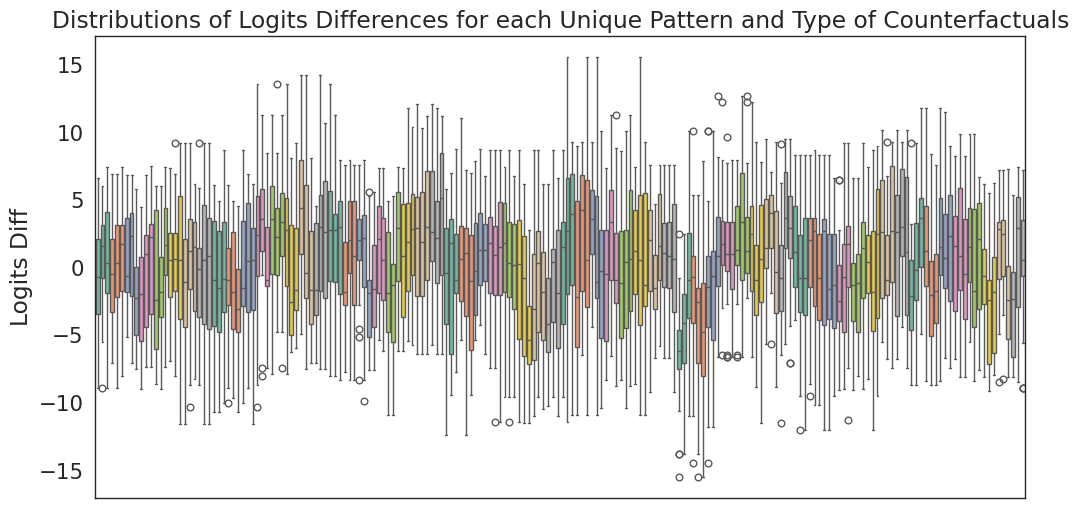

In [733]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

logits_tens = logit_diffs.reshape(3, -1, NUM_SAMPLES).cpu()
reshaped_tensor = logits_tens.view(3*len(patterns), NUM_SAMPLES)

logits_tens = logit_diffs.reshape(3, -1, NUM_SAMPLES).cpu()
reshaped_tensor = logits_tens.view(3*len(patterns), NUM_SAMPLES)

# Prepare the data for plotting
data = reshaped_tensor.numpy().T  # Transpose to have NUM_SAMPLES distributions of length 3*len(patterns)
df = pd.DataFrame(data)

df = df.melt(var_name='Group', value_name='Logits Diff')
df['Dim2'] = df['Group'] // 3

# Plotting
plt.figure(figsize=(12, 6))
sns.boxplot(x='Group', y='Logits Diff', hue='Dim2', data=df, palette='Set2')

# Remove the legend
plt.legend([],[], frameon=False)


plt.xlabel('')
plt.xticks([])
plt.title('Distributions of Logits Differences for each Unique Pattern and Type of Counterfactuals')
plt.show()

In [20]:
# Patterns are in some sense symmetric 
# if "synonym" behavior is all 0 - we only consider synonym pairs 
# if "synonym" behavior is all 1 - we only consider antonym pairs
# if "language" behavior is all 0 - we always remain within one language 
# if "language" behavior is all 1 - we always translate between languages
# it is interesting if synonym pairs vs antonym  pairs should be considered similar up to reflection
# or, similarly to language transorms, they relate as "identity" transform and "side-step" from the origin

pattern_sym_groups = np.sum(np.array(patterns), axis=-1)
pattern_sym_groups[pattern_sym_groups==2] = 0  # 2 and 0 are identical
pattern_sym_groups = [tuple(r) for r in pattern_sym_groups.tolist()]
unique_patterns = list(set(pattern_sym_groups))
pattern_colors = [unique_patterns.index(pat) for pat in  pattern_sym_groups]

In [21]:
# we also want to match counterfactual types to the pattern in use
# for that we also need to keep track of the number of pairs (we use length=5) to index the pattern
# and decide which type of counterfactual is the most challenging for the model
# counterfactuals are ordered as "synonym, antonym, lang, antonym-lang" but we exclude one of them which is choses as a True Answer
# 

In [738]:
df

,Group,Logits Diff,Dim2
0,0,4.244935,0
1,0,-0.750328,0
2,0,0.012775,0
3,0,0.001282,0
4,0,6.587385,0
...,...,...,...
5755,191,7.179964,63
5756,191,-0.100761,63
5757,191,4.964532,63
5758,191,-0.100761,63


In [832]:
# df['Pattern_Type'].value_counts()

In [740]:
import pandas as pd
import plotly.express as px

# Example tensors
NUM_SAMPLES = 30

logits_tens = logit_diffs.reshape(3, -1, NUM_SAMPLES).cpu()
reshaped_tensor = logits_tens.view(3*len(patterns), NUM_SAMPLES)

# Prepare the data for plotting
data = reshaped_tensor.numpy().T  # Transpose to have NUM_SAMPLES distributions of length 3*len(patterns)
df = pd.DataFrame(data)

# Melt the dataframe and create a column for Dim2 grouping by 3
df = df.melt(var_name='Group', value_name='Value')
df['Counterfactual_Type'] = np.tile((1,2,3), NUM_SAMPLES*len(pattern_colors))
df['Pattern_Type'] = np.repeat(3*pattern_colors, NUM_SAMPLES)
df['Pattern_Tuple'] = [unique_patterns[idx] for idx in df['Pattern_Type']]

df = df.sort_values(by='Pattern_Type')
df = df.rename(columns={'Value':'Logit Diff', 'Group':'Sentence Pattern'})
# Create the boxplot using plotly express
fig = px.box(df, x='Pattern_Type', y='Logit Diff', color='Counterfactual_Type', title='Boxplots Colored by Second Dimension', hover_data='Pattern_Tuple')


# Update layout to place the legend outside the plot
fig.update_layout(
    legend_title_text='Counterfactual Type',
    legend=dict(
        x=1.05,
        y=1,
        traceorder='normal',
        bgcolor='rgba(255,255,255,0)',
        bordercolor='rgba(255,255,255,0)'
    ),
    margin=dict(l=0, r=150, t=50, b=50),
    xaxis_title='Pattern Tuple',  # Update x-axis title
    xaxis_tickangle=-45  # Rotate x-axis ticks for better readability if needed
)

# Show the plot
fig.show()

In [32]:
unique_patterns

[(1, 0, 1),
 (1, 1, 0),
 (0, 1, 0),
 (0, 0, 0),
 (1, 0, 0),
 (0, 0, 1),
 (1, 1, 1),
 (0, 1, 1)]

In [22]:
# memory runs out when subsequent steps are executed on all patterns simultaneously 
# we select the most challenging patterns with the most oscillatory interactions

selected_patterns = [(0,0,0,), (0, 1, 0), (0, 0, 1), (1,1,1)]

indice_pattern_full = {}
indice_pattern_sym = {}
c = 0
for pat in patterns:
    for i in range(NUM_SAMPLES):
        c += 1
        tp = tuple(np.array(pat).sum(axis=1))
        if tp in selected_patterns:
            indice_pattern_full[c] = pat
            tp = [t if t!=2 else 0 for t in tp ]
            indice_pattern_sym[c] = tuple(tp)

selected_indices = np.array(list(indice_pattern_full))
indx_to_pat_type = [unique_patterns.index(s) for s in indice_pattern_sym.values()]

all_sele_logits = []
pattern_to_cache = {}
pattern_to_idx = {}
for unique_pat in set(indx_to_pat_type):
    sele = np.where(np.array(indx_to_pat_type)==unique_pat)[0]
    pattern_to_idx[unique_pat] = sele

    original_logits, cache = model.run_with_cache(tokens[selected_indices[sele]])
    pattern_to_cache[unique_pat] = cache
    all_sele_logits.append(original_logits)

all_sele_logits = torch.concat(all_sele_logits, dim=0)
selected_logits_diff = logits_to_ave_logit_diff(original_logits, all_answer_tokens[:,selected_indices].to(device), per_prompt=True)

In [25]:
answer_residual_directions = model.tokens_to_residual_directions(all_answer_tokens[:,selected_indices])
print("Answer residual directions shape:", answer_residual_directions.shape)
logit_diff_directions = (
    answer_residual_directions[0, None, :] - answer_residual_directions[1:, :]
)
logit_diff_directions = logit_diff_directions.mean(dim=0)
print("Logit difference directions shape:", logit_diff_directions.shape)

Answer residual directions shape: torch.Size([4, 390, 768])
Logit difference directions shape: torch.Size([390, 768])


In [23]:
for unique_pat in set(indx_to_pat_type):
    print(unique_pat, len(pattern_to_idx[unique_pat]))

2 60
3 30
5 60
6 240


In [26]:
# cache syntax - resid_post is the residual stream at the end of the layer, -1 gets the final layer. The general syntax is [activation_name, layer_index, sub_layer_type].
all_average_logit_diffs = {}
for unique_pat in set(indx_to_pat_type):
    sele = pattern_to_idx[unique_pat]
    cache = pattern_to_cache[unique_pat]
    final_residual_stream = cache["resid_post", -1]
    print("Final residual stream shape:", final_residual_stream.shape)
    final_token_residual_stream = final_residual_stream[:, -1, :]
    # Apply LayerNorm scaling
    # pos_slice is the subset of the positions we take - here the final token of each prompt
    scaled_final_token_residual_stream = cache.apply_ln_to_stack(
        final_token_residual_stream, layer=-1, pos_slice=-1
    )

    average_logit_diff = einsum(
        "batch d_model, batch d_model -> ",
        scaled_final_token_residual_stream,
        logit_diff_directions[sele,:],
    ) / len(indice_pattern_full)
    all_average_logit_diffs[unique_pat] = average_logit_diff
    print("Calculated average logit diff:", round(average_logit_diff.item(), 3))
    # print("Original logit difference:", round(original_average_logit_diff.item(), 3))

Final residual stream shape: torch.Size([60, 48, 768])
Calculated average logit diff: -0.117
Final residual stream shape: torch.Size([30, 48, 768])
Calculated average logit diff: 0.02
Final residual stream shape: torch.Size([60, 48, 768])
Calculated average logit diff: 0.282
Final residual stream shape: torch.Size([240, 48, 768])
Calculated average logit diff: 0.186


In [27]:
def residual_stack_to_logit_diff(
    residual_stack: Float[torch.Tensor, "components batch d_model"],
    cache: ActivationCache,
    logit_diff_directions: torch.Tensor
    
) -> float:
    scaled_residual_stack = cache.apply_ln_to_stack(
        residual_stack, layer=-1, pos_slice=-1
    )
    return einsum(
        "... batch d_model, batch d_model -> ...",
        scaled_residual_stack,
        logit_diff_directions,
    ) / len(indice_pattern_full)

In [28]:
def imshow(tensor, **kwargs):
    px.imshow(
        utils.to_numpy(tensor),
        color_continuous_midpoint=0.0,
        color_continuous_scale="RdBu",
        **kwargs,
    ).show()


def line(tensors, labels=None, **kwargs):
    # Check if tensors is a list of tensors
    if not isinstance(tensors, list):
        raise ValueError("tensors should be a list of tensors")

    # If no labels are provided, create default labels
    if labels is None:
        labels = [f"Line {i+1}" for i in range(len(tensors))]
    
    # Validate that the number of labels matches the number of tensors
    if len(labels) != len(tensors):
        raise ValueError("The number of labels must match the number of tensors")
    
    # Convert tensors to numpy arrays and create a dictionary for Plotly
    data = {
        'Value': [],
        'Index': [],
        'Label': []
    }
    
    for i, tensor in enumerate(tensors):
        tensor_np = np.squeeze(np.array(tensor.cpu()))
        if tensor_np.ndim != 1:
            raise ValueError(f"Tensor at index {i} is not 1D after squeezing")
        
        tensor_length = len(tensor_np)
        data['Value'].extend(tensor_np)
        data['Index'].extend(np.arange(tensor_length))
        data['Label'].extend([labels[i]] * tensor_length)
    
    # Create the line plot using Plotly Express
    fig = px.line(
        x=data['Index'],
        y=data['Value'],
        color=data['Label'],
        labels={"color": "Label"},
        **kwargs
    )
    
    # Show the plot
    fig.show()


def scatter(x, y, xaxis="", yaxis="", caxis="", **kwargs):
    x = utils.to_numpy(x)
    y = utils.to_numpy(y)
    px.scatter(
        y=y,
        x=x,
        labels={"x": xaxis, "y": yaxis, "color": caxis},
        **kwargs,
    ).show()

In [29]:
all_logit_lens_logit_diffs = []

for unique_pat in set(indx_to_pat_type):
    sele = pattern_to_idx[unique_pat]
    cache = pattern_to_cache[unique_pat]
    accumulated_residual, labels = cache.accumulated_resid(layer=-1, incl_mid=True,
                                                            pos_slice=-1, return_labels=True)
    logit_lens_logit_diffs = residual_stack_to_logit_diff(accumulated_residual, cache, logit_diff_directions[sele,:])
    all_logit_lens_logit_diffs.append(logit_lens_logit_diffs)

In [59]:
[unique_patterns[unique_pat] for unique_pat in set(indx_to_pat_type)]

[(0, 1, 0), (0, 0, 0), (0, 0, 1), (1, 1, 1)]

In [30]:
line(
    all_logit_lens_logit_diffs,
    labels= [unique_patterns[unique_pat] for unique_pat in set(indx_to_pat_type)],
    # x=np.arange(model.cfg.n_layers * 2 + 1) / 2,
    #hover_name=labels,
    title="Logit Difference From Accumulate Residual Stream; Labels indicate Switching every second pair of (Connector, Language, Antonym)",
)

In [63]:
set(indx_to_pat_type)

{2, 3, 5, 6}

In [77]:
unique_patterns[6]

(1, 1, 1)

In [68]:
per_head_logit_diffs_all = {}

for unique_pat in set(indx_to_pat_type):
    sele = pattern_to_idx[unique_pat]
    cache = pattern_to_cache[unique_pat]

    per_head_residual, labels = cache.stack_head_results(
        layer=-1, pos_slice=-1, return_labels=True
    )
    per_head_logit_diffs = residual_stack_to_logit_diff(per_head_residual, cache, logit_diff_directions[sele,:])
    per_head_logit_diffs = einops.rearrange(
        per_head_logit_diffs,
        "(layer head_index) -> layer head_index",
        layer=model.cfg.n_layers,
        head_index=model.cfg.n_heads,
    )
    per_head_logit_diffs_all[unique_pat] = per_head_logit_diffs
    imshow(
        per_head_logit_diffs,
        labels={"x": "Head", "y": "Layer"},
        title="Logit Difference From Each Head",
    )

Tried to stack head results when they weren't cached. Computing head results now


Tried to stack head results when they weren't cached. Computing head results now


Tried to stack head results when they weren't cached. Computing head results now


Tried to stack head results when they weren't cached. Computing head results now


In [69]:
def visualize_attention_patterns(
    heads: Union[List[int], int, Float[torch.Tensor, "heads"]],
    local_cache: ActivationCache,
    local_tokens: torch.Tensor,
    title: Optional[str] = "",
    max_width: Optional[int] = 700,
) -> str:
    # If a single head is given, convert to a list
    if isinstance(heads, int):
        heads = [heads]

    # Create the plotting data
    labels: List[str] = []
    patterns: List[Float[torch.Tensor, "dest_pos src_pos"]] = []

    # Assume we have a single batch item
    batch_index = 0

    for head in heads:
        # Set the label
        layer = head // model.cfg.n_heads
        head_index = head % model.cfg.n_heads
        labels.append(f"L{layer}H{head_index}")

        # Get the attention patterns for the head
        # Attention patterns have shape [batch, head_index, query_pos, key_pos]
        patterns.append(local_cache["attn", layer][batch_index, head_index])

    # Convert the tokens to strings (for the axis labels)
    str_tokens = model.to_str_tokens(local_tokens)

    # Combine the patterns into a single tensor
    patterns: Float[torch.Tensor, "head_index dest_pos src_pos"] = torch.stack(
        patterns, dim=0
    )

    # Circuitsvis Plot (note we get the code version so we can concatenate with the title)
    plot = attention_heads(
        attention=patterns, tokens=str_tokens, attention_head_names=labels
    ).show_code()

    # Display the title
    title_html = f"<h2>{title}</h2><br/>"

    # Return the visualisation as raw code
    return f"<div style='max-width: {str(max_width)}px;'>{title_html + plot}</div>"

In [69]:
pattern_to_cache.keys()

dict_keys([2, 3, 5, 6])

In [75]:
top_k = 3

k = 6
l = 8
cache = pattern_to_cache[k]
sele = pattern_to_idx[k]
per_head_logit_diffs = per_head_logit_diffs_all[k]

top_positive_logit_attr_heads = torch.topk(
    per_head_logit_diffs.flatten(), k=top_k
).indices

positive_html = visualize_attention_patterns(
    top_positive_logit_attr_heads,
    cache,
    tokens[selected_indices[sele]][l],
    f"Top {top_k} Positive Logit Attribution Heads",
)

top_negative_logit_attr_heads = torch.topk(
    -per_head_logit_diffs.flatten(), k=top_k
).indices

negative_html = visualize_attention_patterns(
    top_negative_logit_attr_heads,
    cache,
    tokens[selected_indices[sele]][l],
    title=f"Top {top_k} Negative Logit Attribution Heads",
)

print("".join(model.to_str_tokens(tokens[selected_indices[sele]][l])))
HTML(positive_html + negative_html)

<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>bon or vertueux, gagner and lose, activé or en marche, mâle and female, positif or affirmatif, droit and


In [1185]:
model.unembed.b_U.sum()

tensor(0., device='mps:0')

In [31]:
k = 5
sele = pattern_to_idx[k]
sele_prompts = [all_prompts_flat[p] for p in selected_indices[sele]]
len(sele_prompts)

60

In [33]:
corrupted_logits.shape

torch.Size([60, 48, 50257])

In [34]:
answer_tokens[selected_indices[sele]].shape

torch.Size([60])

In [35]:
answer_tokens[selected_indices[sele]]

tensor([   69,  2364,   525, 36460,  7617, 36460,    85,    75, 13159, 49075,
         2302, 43435, 12093,  2364,    82, 28920, 21378,    82,    85, 36460,
         7617, 21953,   525, 43435,    79,    82,    82,    75,    77, 29370,
         1851,  2001, 11664,   805, 44070, 33106,  2787, 29370,  3876, 33106,
         1671,  2001,  1671, 29199, 26452,  2001,   634, 30283,    67,    83,
         1671, 11664,    69,   259, 30283,   259,    69,  9464,  3262, 32165],
       device='mps:0')

In [36]:
corrupted_prompts = []
for i in range(len(sele_prompts)):
    pr = sele_prompts[i]
    pr = pr.rstrip('or')
    pr += 'and'
    corrupted_prompts.append(pr)

    
corrupted_tokens = model.to_tokens(corrupted_prompts, prepend_bos=True)
corrupted_logits, corrupted_cache = model.run_with_cache(
    corrupted_tokens, return_type="logits"
)
corrupted_average_logit_diff = logits_to_ave_logit_diff(corrupted_logits, answer_tokens[selected_indices[sele]].unsqueeze(1))
print("Corrupted Average Logit Diff", round(corrupted_average_logit_diff.item(), 2))
print("Clean Average Logit Diff", round(all_average_logit_diffs[k].item(), 2))

Corrupted Average Logit Diff -0.5
Clean Average Logit Diff 0.28


In [37]:
sele_prompts[:3]

['commencer or débuter, haut or bas, bon or vertueux, grand or petit, droit or correct, vrai or',
 'hot or warm, left or right, alive or living, yes or no, inside or inward, on or',
 'haut or au-dessus, allumé or éteint, plein or rempli, intérieur or extérieur, ouvert or déverrouillé, gagner or']

In [133]:
corrupted_prompts[:3]

['ouvert or déverrouillé, gauche or droite, heureux or joyeux, riche or pauvre, gagner or réussir, vrai and',
 'light or bright, male or female, true or correct, full or empty, present or here, hot and',
 'jour or journée, ouvert or fermé, intérieur or dedans, oui or non, haut or au-dessus, propre and']

In [42]:
original_average_logit_diff = all_average_logit_diffs[k]

In [49]:
corrupted_tokens.shape

torch.Size([60, 48])

In [74]:
def patch_residual_component(
    corrupted_residual_component: Float[torch.Tensor, "batch pos d_model"],
    hook,
    pos,
    clean_cache,
):
    # print(corrupted_residual_component.shape)
    # print(clean_cache[hook.name].shape)
    corrupted_residual_component[:, pos, :] = clean_cache[hook.name][:, pos, :]
    return corrupted_residual_component


def normalize_patched_logit_diff(patched_logit_diff):
    # Subtract corrupted logit diff to measure the improvement, divide by the total improvement from clean to corrupted to normalise
    # 0 means zero change, negative means actively made worse, 1 means totally recovered clean performance, >1 means actively *improved* on clean performance
    return (patched_logit_diff - corrupted_average_logit_diff) / (
        original_average_logit_diff - corrupted_average_logit_diff
    )

k = 5
sele = pattern_to_idx[k]
tokks = tokens[selected_indices[sele]]

cache = pattern_to_cache[k]
patched_residual_stream_diff = torch.zeros(
    model.cfg.n_layers, tokks.shape[1], device=device, dtype=torch.float32
)
for layer in range(model.cfg.n_layers):
    for position in range(tokks.shape[1]):
        try:
            hook_fn = partial(patch_residual_component, pos=position, clean_cache=cache)
            patched_logits = model.run_with_hooks(
                corrupted_tokens,
                fwd_hooks=[(utils.get_act_name("resid_pre", layer), hook_fn)],
                return_type="logits",
            )
            patched_logit_diff = logits_to_ave_logit_diff(patched_logits, answer_tokens[selected_indices[sele]].unsqueeze(1))

            patched_residual_stream_diff[layer, position] = normalize_patched_logit_diff(
                patched_logit_diff
            )
        except:
            pass

In [76]:
prompt_position_labels = [
    f"{tok}_{i}" for i, tok in enumerate(model.to_str_tokens(tokks[0]))
]
imshow(
    patched_residual_stream_diff,
    x=prompt_position_labels,
    title="Logit Difference From Patched Residual Stream",
    labels={"x": "Position", "y": "Layer"},
)

In [78]:
def patch_head_vector(
    corrupted_head_vector: Float[torch.Tensor, "batch pos head_index d_head"],
    hook,
    head_index,
    clean_cache,
):
    corrupted_head_vector[:, :, head_index, :] = clean_cache[hook.name][
        :, :, head_index, :
    ]
    return corrupted_head_vector


patched_head_z_diff = torch.zeros(
    model.cfg.n_layers, model.cfg.n_heads, device=device, dtype=torch.float32
)
for layer in range(model.cfg.n_layers):
    for head_index in range(model.cfg.n_heads):
        hook_fn = partial(patch_head_vector, head_index=head_index, clean_cache=cache)
        patched_logits = model.run_with_hooks(
            corrupted_tokens,
            fwd_hooks=[(utils.get_act_name("z", layer, "attn"), hook_fn)],
            return_type="logits",
        )
        patched_logit_diff = logits_to_ave_logit_diff(patched_logits, answer_tokens[selected_indices[sele]].unsqueeze(1))

        patched_head_z_diff[layer, head_index] = normalize_patched_logit_diff(
            patched_logit_diff
        )

In [79]:
imshow(
    patched_head_z_diff,
    title="Logit Difference From Patched Head Output",
    labels={"x": "Head", "y": "Layer"},
)

In [80]:
patched_head_v_diff = torch.zeros(
    model.cfg.n_layers, model.cfg.n_heads, device=device, dtype=torch.float32
)
for layer in range(model.cfg.n_layers):
    for head_index in range(model.cfg.n_heads):
        hook_fn = partial(patch_head_vector, head_index=head_index, clean_cache=cache)
        patched_logits = model.run_with_hooks(
            corrupted_tokens,
            fwd_hooks=[(utils.get_act_name("v", layer, "attn"), hook_fn)],
            return_type="logits",
        )
        patched_logit_diff = logits_to_ave_logit_diff(patched_logits, answer_tokens[selected_indices[sele]].unsqueeze(1))

        patched_head_v_diff[layer, head_index] = normalize_patched_logit_diff(
            patched_logit_diff
        )

In [82]:
head_labels = [
    f"L{l}H{h}" for l in range(model.cfg.n_layers) for h in range(model.cfg.n_heads)
]
scatter(
    x=utils.to_numpy(patched_head_v_diff.flatten()),
    y=utils.to_numpy(patched_head_z_diff.flatten()),
    xaxis="Value Patch",
    yaxis="Output Patch",
    caxis="Layer",
    hover_name=head_labels,
    color=einops.repeat(
        np.arange(model.cfg.n_layers), "layer -> (layer head)", head=model.cfg.n_heads
    ),
    range_x=(-0.5, 0.5),
    range_y=(-0.5, 0.5),
    title="Scatter plot of output patching vs value patching",
)

In [87]:
def patch_head_pattern(
    corrupted_head_pattern: Float[torch.Tensor, "batch head_index query_pos d_head"],
    hook,
    head_index,
    clean_cache,
):
    corrupted_head_pattern[:, head_index, :, :] = clean_cache[hook.name][
        :, head_index, :, :
    ]
    return corrupted_head_pattern


patched_head_attn_diff = torch.zeros(
    model.cfg.n_layers, model.cfg.n_heads, device=device, dtype=torch.float32
)
for layer in range(model.cfg.n_layers):
    for head_index in range(model.cfg.n_heads):
        hook_fn = partial(patch_head_pattern, head_index=head_index, clean_cache=cache)
        patched_logits = model.run_with_hooks(
            corrupted_tokens,
            fwd_hooks=[(utils.get_act_name("attn", layer, "attn"), hook_fn)],
            return_type="logits",
        )
        patched_logit_diff = logits_to_ave_logit_diff(patched_logits, answer_tokens[selected_indices[sele]].unsqueeze(1))

        patched_head_attn_diff[layer, head_index] = normalize_patched_logit_diff(
            patched_logit_diff
        )

In [88]:
imshow(
    patched_head_attn_diff,
    title="Logit Difference From Patched Head Pattern",
    labels={"x": "Head", "y": "Layer"},
)
head_labels = [
    f"L{l}H{h}" for l in range(model.cfg.n_layers) for h in range(model.cfg.n_heads)
]
scatter(
    x=utils.to_numpy(patched_head_attn_diff.flatten()),
    y=utils.to_numpy(patched_head_z_diff.flatten()),
    hover_name=head_labels,
    xaxis="Attention Patch",
    yaxis="Output Patch",
    title="Scatter plot of output patching vs attention patching",
)

In [ ]:
# Mathematical binaries
# ('add', 'subtract'),
# ('multiply', 'divide'),
# ('even', 'odd'),
# ('finite', 'infinite'),
# ('rational', 'irrational'),
# ('integer', 'fraction'),
# ('prime', 'composite'),
# ('real', 'imaginary'),
# ('convergent', 'divergent'),
# ('greater', 'less'),
# ('equal', 'unequal'),
# ('increase', 'decrease'),
# ('ascending', 'descending'),
# ('concave', 'convex'),
# ('continuous', 'discrete'),
# ('bounded', 'unbounded'),
# ('orthogonal', 'parallel'),
# ('symmetric', 'asymmetric'),
# ('linear', 'nonlinear'),
# ('deterministic', 'stochastic'),
# ('constant', 'variable')